### Imports

In [46]:
import time
import wandb
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, r2_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier,  DecisionTreeRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, KFold

import warnings
warnings.filterwarnings('ignore')

### Utils

#### Variables

In [47]:
wine_dataset_path = "./Datasets/WineQT.csv"
housing_dataset_path = "./Datasets/HousingData.csv"

random_state = 42
mlp = False

#### Base Models

In [48]:
class MLP_Regression:
    def __init__(self, input_size, hidden_layers, output_size=1, learning_rate=0.01, activation='sigmoid', optimizer='sgd', print_every=None, wandb_log=False, max_epochs=10, batch_size=32):
        assert activation.lower() in ['sigmoid', 'relu', 'tanh'], "Activation function must be either 'sigmoid', 'relu' or 'tanh'"
        assert optimizer.lower() in ['sgd', 'bgd', 'mbgd'], "Optimizer must be either 'sgd', 'bgd' or 'mbgd'"
        assert input_size > 0, "Input size must be greater than 0"
        assert output_size > 0, "Output size must be greater than 0"
        assert learning_rate > 0, "Learning rate must be greater than 0"
        assert type(hidden_layers) == list and len(hidden_layers) > 0, "Hidden layers must be a list of size greater than 0"

        self.input_size = input_size
        self.hidden_layers = hidden_layers
        self.output_size = output_size
        self.learning_rate = learning_rate
        self.optimizer = optimizer
        self.activation_func = self._get_activation_func(activation)
        self.optimizer_func = self._get_optimizer_func(optimizer)
        self.weights, self.biases = self._initialize_weights_and_biases()

        self.wandb_log = wandb_log
        self.print_every = print_every
        self.max_epochs = max_epochs
        self.batch_size = batch_size

    # Activation functions
    def _get_activation_func(self, activation):
        if activation == "sigmoid":
            return self._sigmoid
        elif activation == "tanh":
            return self._tanh
        elif activation == "relu":
            return self._relu
        else:
            raise ValueError(f"Activation function '{activation}' not supported.")

    def _sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def _tanh(self, x):
        return np.tanh(x)

    def _relu(self, x):
        return np.maximum(0, x)

    # Activation derivative
    def _activation_derivative(self, Z):
        if self.activation_func == self._sigmoid:
            return self._sigmoid_derivative(Z)
        elif self.activation_func == self._tanh:
            return self._tanh_derivative(Z)
        elif self.activation_func == self._relu:
            return self._relu_derivative(Z)
        else:
            raise ValueError(
                f"Activation function '{self.activation_func}' not supported."
            )

    def _sigmoid_derivative(self, Z):
        return self._sigmoid(Z) * (1 - self._sigmoid(Z))

    def _tanh_derivative(self, Z):
        return 1 - np.square(self._tanh(Z))

    def _relu_derivative(self, Z):
        return np.where(Z > 0, 1, 0)

    # Optimizers
    def _get_optimizer_func(self, optimizer):
        if optimizer == "sgd":
            return self._sgd
        elif optimizer == "bgd":
            return self._bgd
        elif optimizer == "mbgd":
            return self._mbgd
        else:
            raise ValueError(f"Optimizer '{optimizer}' not supported.")

    def _sgd(self, grads):
        for i in range(len(self.weights)):
            self.weights[i] -= self.learning_rate * grads["dW"][i]
            self.biases[i] -= self.learning_rate * grads["db"][i]

    def _bgd(self, grads):
        for i in range(len(self.weights)):
            self.weights[i] -= self.learning_rate * grads["dW"][i] / self.input_size
            self.biases[i] -= self.learning_rate * grads["db"][i] / self.input_size

    def _mbgd(self, grads):
        for i in range(len(self.weights)):
            self.weights[i] -= (
                self.learning_rate * grads["dW"][i] / grads["dW"][i].shape[1]
            )
            self.biases[i] -= (
                self.learning_rate * grads["db"][i] / grads["db"][i].shape[1]
            )

    # Initialize weights and biases
    def _initialize_weights_and_biases(self):
        num_layers = len(self.hidden_layers)
        weights = []
        biases = []

        if num_layers == 0:
            w = np.random.randn(self.input_size, self.output_size)
            b = np.zeros((1, self.output_size))
            weights.append(w)
            biases.append(b)
            return weights, biases

        # Using Github Copilot
        for i in range(num_layers + 1):
            if i == 0:
                w = 0.01 * np.random.randn(self.input_size, self.hidden_layers[0])
            elif i == num_layers:
                w = 0.01 * np.random.randn(self.hidden_layers[-1], self.output_size)
            else:
                w = 0.01 * np.random.randn(
                    self.hidden_layers[i - 1], self.hidden_layers[i]
                )

            b = np.zeros((1, w.shape[1]))
            weights.append(w)
            biases.append(b)

        return weights, biases

    # Forward propagation
    def _forward_propagation(self, X):
        num_layers = len(self.weights)
        A = X
        caches = []

        for i in range(num_layers):
            W = self.weights[i]
            b = self.biases[i]

            Z = np.dot(A, W) + b

            if Z.shape[1] == 1:
                Z = Z.reshape(-1)
            caches.append((A, W, b, Z))
            # print("Forward", A.shape, W.shape, b.shape, Z.shape)

            A = self.activation_func(Z)

        if len(A.shape) == 1:
            A = A.reshape(-1)
        return A, caches

    # Backward propagation
    def _backward_propagation(self, A, Y, caches):
        num_samples = A.shape[0]
        num_layers = len(self.weights)
        grads = {"dW": [], "db": []}

        delta = A - Y
        # print(delta.shape, A.shape, Y.shape)

        for i in reversed(range(num_layers)):
            A, W, _, Z = caches[i]
            # print("A", A.shape, "W", W.shape, "Z", Z.shape)

            dZ = np.multiply(delta, self._activation_derivative(Z))
            if dZ.ndim == 1:
                dZ = dZ.reshape((dZ.shape[0], 1))
            # print("dZ", dZ.shape)
            dW = np.dot(A.T, dZ)
            # print("dW", dW.shape)
            db = np.sum(dZ, axis=0, keepdims=True)
            # print("db", db.shape)

            delta = np.dot(dZ, W.T)
            # print("delta", delta.shape)

            if len(dW.shape) == 1:
                dW = dW.reshape(-1, 1)

            grads["dW"].append(dW)
            grads["db"].append(db)

        grads["dW"].reverse()
        grads["db"].reverse()

        return grads

    # Calculate cost
    def _calculate_cost(self, A, Y):
        # print(A.shape, Y.shape)
        mse = np.mean(np.square(A - Y))
        rmse = np.sqrt(mse)
        r_squred = 1 - (np.sum(np.square(Y - A)) / np.sum(np.square(Y - np.mean(Y))))
        return mse, rmse, r_squred

    # Predict
    def predict(self, X):
        A, _ = self._forward_propagation(X)
        return A
    
    # Evaluate
    def evaluate(self, X, Y):
        A = self.predict(X)
        mse, rmse, r_squared = self._calculate_cost(A, Y)
        return mse, rmse, r_squared

    def fit(self, X, Y, X_validation=None, y_validation=None):
        return self.train(X, Y, X_validation, y_validation)

    # Train the model
    def train(self, X, Y, X_validation=None, y_validation=None):
        num_samples = X.shape[0]
        costs = []
        max_epochs = self.max_epochs
        batch_size = self.batch_size

        for i in range(max_epochs):
            if self.optimizer == "bgd":
                batch_size = num_samples
                num_batches = 1
            elif self.optimizer == "sgd":
                batch_size = 1
                num_batches = num_samples
            elif self.optimizer == "mbgd":
                num_batches = num_samples // batch_size
            else:
                raise ValueError(f"Optimizer '{self.optimizer}' not supported.")

            for j in range(num_batches):
                start = j * batch_size
                end = start + batch_size

                A, caches = self._forward_propagation(X[start:end])
                grads = self._backward_propagation(A, Y[start:end], caches)
                self.optimizer_func(grads)

            A = self.predict(X)
            mse, rmse, r_squared = self._calculate_cost(A, Y)
            costs.append(mse)

            data_to_log = {"epoch": i + 1, "train_loss": mse}

            # Calculate validation loss
            if X_validation is not None and y_validation is not None:
                A = self.predict(X_validation)
                val_loss_mse, val_loss_rmse, val_loss_r_squared = self._calculate_cost(A, y_validation)
                data_to_log["val_loss"] = val_loss_mse

            if self.wandb_log:
                wandb.log(data_to_log)

            if self.print_every and (i + 1) % self.print_every == 0:
                print(f"Cost after {i+1} epochs: {mse}")

        return costs

In [49]:
class MLP_Classifier:
    def __init__(self, input_size, hidden_layers, num_classes=11, learning_rate=0.01, activation='sigmoid', optimizer='sgd', wandb_log=False, print_every=None, max_epochs=10, batch_size=32):
        assert activation.lower() in ['sigmoid', 'relu', 'tanh'], "Activation function must be either 'sigmoid', 'relu' or 'tanh'"
        assert optimizer.lower() in ['sgd', 'bgd', 'mbgd'], "Optimizer must be either 'sgd', 'bgd' or 'mbgd'"
        assert input_size > 0, "Input size must be greater than 0"
        assert num_classes > 0, "Output size must be greater than 0"
        assert learning_rate > 0, "Learning rate must be greater than 0"
        assert type(hidden_layers) == list and len(hidden_layers) > 0, "Hidden layers must be a list of size greater than 0"

        self.input_size = input_size
        self.hidden_layers = hidden_layers
        self.output_size = num_classes
        self.learning_rate = learning_rate
        self.optimizer = optimizer
        self.activation_func = self._get_activation_func(activation)
        self.optimizer_func = self._get_optimizer_func(optimizer)
        self.weights, self.biases = self._initialize_weights_and_biases()

        self.wandb_log = wandb_log
        self.print_every = print_every
        self.max_epochs = max_epochs
        self.batch_size = batch_size
    
    # Activation functions
    def _get_activation_func(self, activation):
        if activation == 'sigmoid':
            return self._sigmoid
        elif activation == 'tanh':
            return self._tanh
        elif activation == 'relu':
            return self._relu
        else:
            raise ValueError(f"Activation function '{activation}' not supported.")

    def _sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def _tanh(self, x):
        return np.tanh(x)

    def _relu(self, x):
        return np.maximum(0, x)
    
    # Activation derivative
    def _activation_derivative(self, Z):
        if self.activation_func == self._sigmoid:
            return self._sigmoid_derivative(Z)
        elif self.activation_func == self._tanh:
            return self._tanh_derivative(Z)
        elif self.activation_func == self._relu:
            return self._relu_derivative(Z)
        else:
            raise ValueError(f"Activation function '{self.activation_func}' not supported.")
    
    def _sigmoid_derivative(self, Z):
        return self._sigmoid(Z) * (1 - self._sigmoid(Z))
    
    def _tanh_derivative(self, Z):
        return 1 - np.square(self._tanh(Z))
    
    def _relu_derivative(self, Z):
        return np.where(Z > 0, 1, 0)
    
    ## Optimizers
    def _get_optimizer_func(self, optimizer):
        if optimizer == 'sgd':
            return self._sgd
        elif optimizer == 'bgd':
            return self._bgd
        elif optimizer == 'mbgd':
            return self._mbgd
        else:
            raise ValueError(f"Optimizer '{optimizer}' not supported.")
    
    def _sgd(self, grads):
        for i in range(len(self.weights)):
            self.weights[i] -= (self.learning_rate * grads['dW'][i])
            self.biases[i] -= (self.learning_rate * grads['db'][i])
    
    def _bgd(self, grads):
        for i in range(len(self.weights)):
            self.weights[i] -= (self.learning_rate * grads['dW'][i] / self.input_size)
            self.biases[i] -= (self.learning_rate * grads['db'][i] / self.input_size)

    def _mbgd(self, grads):
        for i in range(len(self.weights)):
            self.weights[i] -= (self.learning_rate * grads['dW'][i] / grads['dW'][i].shape[1])
            self.biases[i] -= (self.learning_rate * grads['db'][i] / grads['db'][i].shape[1])
    
    # Initialize weights and biases
    def _initialize_weights_and_biases(self):
        num_layers = len(self.hidden_layers)
        weights = []
        biases = []

        if num_layers == 0:
            w = np.random.randn(self.input_size, self.output_size)
            b = np.zeros((1, self.output_size))
            weights.append(w)
            biases.append(b)
            return weights, biases
        
        # Using Github Copilot
        for i in range(num_layers + 1):
            if i == 0:
                w = np.random.randn(self.input_size, self.hidden_layers[0])
            elif i == num_layers:
                w = np.random.randn(self.hidden_layers[-1], self.output_size)
            else:
                w = np.random.randn(self.hidden_layers[i - 1], self.hidden_layers[i])
            
            b = np.zeros((1, w.shape[1]))
            weights.append(w)
            biases.append(b)

        return weights, biases
    
    # Forward propagation
    def _forward_propagation(self, X):
        num_layers = len(self.weights)
        A = X
        caches = []
        
        for i in range(num_layers):
            W = self.weights[i]
            b = self.biases[i]
            Z = np.dot(A, W) + b
            
            if Z.shape[1] == 1:
                Z = Z.reshape(-1)
            caches.append((A, W, b, Z))
            # print(A.shape, W.shape, b.shape, Z.shape)

            A = self.activation_func(Z)
        
        if len(A.shape) == 1:
            A = A.reshape(-1)
        return A, caches

    # Backward propagation
    def _backward_propagation(self, A, Y, caches):
        num_samples = A.shape[0]
        num_layers = len(self.weights)
        grads = {'dW': [], 'db': []}

        delta = A-Y
        # print(delta.shape, A.shape, Y.shape)

        for i in reversed(range(num_layers)):
            A, W, _, Z = caches[i]
            # print("A", A.shape, "W", W.shape, "Z", Z.shape)
            
            dZ = np.multiply(delta, self._activation_derivative(Z))
            if dZ.ndim == 1:
                dZ = dZ.reshape((dZ.shape[0], 1))
            # print("dZ", dZ.shape)
            dW = np.dot(A.T, dZ)
            # print("dW", dW.shape)
            db = np.sum(dZ, axis=0, keepdims=True)
            # print("db", db.shape)

            delta = np.dot(dZ, W.T)
            # print("delta", delta.shape)

            if len(dW.shape) == 1:
                dW = dW.reshape(-1, 1)

            grads['dW'].append(dW)
            grads['db'].append(db)
        
        grads['dW'].reverse()
        grads['db'].reverse()

        return grads
    
    # Calculate cost
    def _calculate_cost(self, A, Y):
        cost = np.mean(np.not_equal(A, Y))
        return cost

    # Predict
    def predict(self, X, return_prob=False):
        A, _ = self._forward_propagation(X)

        # Apply a softmax to get probabilities & then getting the h9ghest probability
        prob = np.exp(A) / np.sum(np.exp(A), axis=1, keepdims=True)

        A = np.argmax(prob,axis=1)

        if return_prob:
            return A, np.max(prob, axis=1)
        return A

    def evaluate(self, X, Y):
        A = self.predict(X)
        return accuracy_score(Y, A)

    def fit(self, X, Y, X_validation=None, y_validation=None):
        return self.train(X, Y, X_validation, y_validation)

    # Train the model
    def train(self, X, Y, X_validation=None, y_validation=None):
        num_samples = X.shape[0]
        costs = []
        max_epochs = self.max_epochs
        batch_size = self.batch_size

        enc = OneHotEncoder().fit(np.array([[i,] for i in range(self.output_size)]))
        y_new = enc.transform(Y.reshape(-1, 1)).toarray()
        
        for i in range(max_epochs):
            if self.optimizer == "bgd":
                batch_size = num_samples
                num_batches = 1
            elif self.optimizer == "sgd":
                batch_size = 1
                num_batches = num_samples
            elif self.optimizer == "mbgd":
                num_batches = num_samples // batch_size
            else:
                raise ValueError(f"Optimizer '{self.optimizer}' not supported.")

            for j in range(num_batches):
                start = j * batch_size
                end = start + batch_size
                
                A, caches = self._forward_propagation(X[start:end])
                grads = self._backward_propagation(A, y_new[start:end], caches)
                self.optimizer_func(grads)
            
            A = self.predict(X)
            cost = self._calculate_cost(A, Y)
            costs.append(cost)

            data_to_log = {
                "epoch": i + 1,
                "train_loss": cost
            }

            # Calculate validation loss
            if X_validation is not None and y_validation is not None:
                A = self.predict(X_validation)
                val_loss = self._calculate_cost(A, y_validation)
                data_to_log["val_loss"] = val_loss

            if self.wandb_log:
                wandb.log(data_to_log)
            
            if self.print_every and (i+1) % self.print_every == 0:
                print(f"Cost after {i+1} epochs: {cost}")
        
        return costs

In [50]:
class Logistic_Regression:
    def __init__(self, num_classes=10, learning_rate=0.01, num_epochs=1000, print_every=None, wandb_log=False):
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.classes = range(num_classes)
        self.weights = [None,] * num_classes
        self.bias = [None,] * num_classes
        self.print_every = print_every
        self.wandb_log = wandb_log
        self.num_classes = num_classes

        self.val_acc = []
        self.train_acc = []

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    
    def softmax(self, z):
        return np.exp(z) / np.sum(np.exp(z), axis=0)
    
    def loss(self, y_true, y_pred):
        return -np.sum(y_true * np.log(y_pred)) / len(y_true)
    
    def fit(self, X, y, X_val=None, y_val=None):
        num_samples, num_features = X.shape
        self.weights = np.zeros((num_features, self.num_classes))
        self.bias = np.zeros(self.num_classes)
        train_loss = []
        self.val_acc = []
        self.train_acc = []

        enc = OneHotEncoder().fit(np.array([[i,] for i in range(self.num_classes)]))
        y_new = enc.transform(y.reshape(-1, 1)).toarray()
        
        for i in range(self.num_epochs):
            z = self.sigmoid(np.dot(X, self.weights) + self.bias[np.newaxis, :])
            y_predicted = self.softmax(z)

            dw = (1 / num_samples) * np.dot(X.T, (y_predicted - y_new))
            db = (1 / num_samples) * np.sum(y_predicted - y_new)

            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

            loss = self.loss(y_new, y_predicted)
            train_loss.append(loss)

            y_predicted_train = self.predict(X)
            self.train_acc.append(self.accuracy(y, y_predicted_train))

            if X_val is not None and y_val is not None:
                y_predicted_val = self.predict(X_val)
                self.val_acc.append(self.accuracy(y_val, y_predicted_val))

            if self.print_every and (i+1) % self.print_every == 0:
                print(f'Epoch {i+1} loss: {loss:.4f}')
                if X_val is not None and y_val is not None:
                    print(f'Val Acc: {self.val_acc[-1]*100:.2f} Train Acc: {self.train_acc[-1]*100:.2f}')
                else:
                    print(f'Train Acc: {self.train_acc[-1]*100:.2f}')

            if self.wandb_log:
                wandb.log({"epoch": i+1,"train_loss": loss, "val_acc": self.val_acc[-1], "train_acc": self.train_acc[-1]})
        
        return train_loss
    
    def predict(self, X, return_prob=False):
        y_predicted = self.softmax(np.dot(X, self.weights) + self.bias[np.newaxis, :])
        y_predicted_cls = np.argmax(y_predicted, axis=1)
        if return_prob:
            return y_predicted_cls, np.max(y_predicted, axis=1)
        return y_predicted_cls
    
    def accuracy(self, y_true, y_pred):
        accuracy = np.sum(y_true == y_pred) / len(y_true)
        return accuracy
    
    def evaluate(self, X, y):
        y_pred = self.predict(X)
        accuracy = self.accuracy(y, y_pred)
        return accuracy
    
    def plot_loss(self, train_loss):
        plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
        plt.title('Training Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.show()

    def plot_acc(self):
        plt.plot(range(1, len(self.val_acc) + 1), self.val_acc, label='Validation Accuracy')
        plt.plot(range(1, len(self.train_acc) + 1), self.train_acc, label='Train Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True)
        plt.show()

In [51]:
class Linear_Regression:
    def __init__(self, learning_rate=0.01, num_epochs=1000, print_every=None, wandb_log=False):
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.weights = None
        self.bias = None
        self.print_every = print_every
        self.wandb_log = wandb_log

        self.train_loss = []

    def fit(self, X, y):
        num_samples, num_features = X.shape
        self.weights = np.zeros(num_features)
        self.bias = 0
        self.train_loss = []

        for i in range(self.num_epochs):
            y_predicted = np.dot(X, self.weights) + self.bias

            error = y_predicted - y
            dw = (1 / num_samples) * np.dot(X.T, error)
            db = (1 / num_samples) * np.sum(error)

            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

            loss = self.loss(y, y_predicted)
            self.train_loss.append(loss)

            if self.print_every and (i+1) % self.print_every == 0:
                print(f'Epoch {i+1} loss: {loss:.4f}')

            if self.wandb_log:
                wandb.log({"epoch": i+1,"train_loss": loss})
        
        return self.train_loss
    
    def predict(self, X):
        y_predicted = np.dot(X, self.weights) + self.bias
        return y_predicted
    
    def loss(self, y_true, y_pred):
        return np.mean(np.square(y_true - y_pred))
    
    def evaluate(self, X, y):
        y_pred = self.predict(X)
        loss = self.loss(y, y_pred)
        return loss
    
    def plot_loss(self):
        plt.plot(range(1, len(self.train_loss) + 1), self.train_loss, label='Training Loss')
        plt.title('Training Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.show()

#### Ensemble Models

In [52]:
class Bagging:
    def __init__(self, base_estimator, best_params, n_estimators=10, fraction=0.15, bootstrap=True, hard_voting=True, classification=True):
        assert fraction > 0 and fraction <= 1, "Fraction must be between 0 and 1"
        assert n_estimators > 0, "Number of estimators must be greater than 0"

        self.base_estimator = base_estimator
        self.best_params = best_params
        self.n_estimators = n_estimators
        self.fraction = fraction
        self.bootstrap = bootstrap
        self.hard_voting = hard_voting
        self.classification = classification

        self.estimators = []
        self.estimators_weights = []

    def _bootstrap(self, X, y, fraction, n):
        data_array = []
        for i in range(n):
            indices = np.random.choice(range(X.shape[0]), size=int(X.shape[0] * fraction))
            data_array.append((X[indices], y[indices]))
        return data_array
    
    def _random_sampling(self, X, y, fraction, n):
        data_array = []
        permuted_index = np.random.permutation(len(X))
        X = X[permuted_index]
        y = y[permuted_index]
        num_samples = int(X.shape[0] * fraction)
        for i in range(num_samples, X.shape[0], num_samples):
            data_array.append((X[i-num_samples: i], y[i-num_samples: i]))
        return data_array[:n]
        
    def fit(self, X, y, X_val, y_val):
        self.estimators_weights = []
        self.estimators = []

        if self.bootstrap==False:
            assert self.fraction * self.n_estimators <= 1
        if self.bootstrap:
            Samples = self._bootstrap(X, y, self.fraction, self.n_estimators)
        else:
            Samples = self._random_sampling(X, y, self.fraction, self.n_estimators)

        for i in range(self.n_estimators):
            X_sample, y_sample = Samples[i]
            
            estimator = self.base_estimator(**self.best_params)
            estimator.fit(X_sample, y_sample)
            self.estimators.append(estimator)

            if self.hard_voting:
                self.estimators_weights.append(1)
            else:
                y_pred = estimator.predict(X_val)
                if self.classification:
                    self.estimators_weights.append(accuracy_score(y_val, y_pred))
                else:
                    self.estimators_weights.append(r2_score(y_val, y_pred))

    def predict(self, X):
        predictions = []
        probs = np.zeros((X.shape[0], self.n_estimators))
        for i, estimator in enumerate(self.estimators):
            if self.classification:
                if estimator.__class__.__name__ == "DecisionTreeClassifier":
                    prediction, prob = estimator.predict(X), [1,]*X.shape[0]
                else:
                    prediction, prob = estimator.predict(X, return_prob=True)
                predictions.append(prediction)
                probs[:, i] = prob
            else:
                predictions.append(estimator.predict(X))
        predictions = np.array(predictions).T

        if self.classification:
            final_predictions = []
            for i, pred in enumerate(predictions):
                final_predictions.append(np.argmax(np.bincount(pred, weights=probs[i, :])))
            return np.array(final_predictions)
        else:
            if self.hard_voting:
                return np.mean(predictions, axis=1)
            else:
                return np.dot(predictions, self.estimators_weights) / np.sum(self.estimators_weights)

    def evaluate(self, X, y):
        y_pred = self.predict(X)
        if self.classification:
            return accuracy_score(y, y_pred)
        else:
            return r2_score(y, y_pred)

In [53]:
class Stacking:
    def __init__(self, base_estimators, final_estimator, final_estimator_params, method='stacking', classification=True, n_fold = 5):
        assert method.lower() in ['stacking', 'blending'], "Method must be either 'stacking' or 'blending'"

        self.base_estimators = base_estimators
        self.final_estimator = final_estimator(**final_estimator_params)
        self.method = method
        self.classification = classification
        self.n_fold = n_fold
    
    def fit(self, X, y):
        kf = KFold(n_splits=self.n_fold)
        X_new = X.copy()
        no_estimators = len(self.base_estimators)

        if self.method == 'stacking':
            new_column = np.zeros((X.shape[0], no_estimators))
            for train_index, test_index in kf.split(X):
                X_train, X_test = X[train_index], X[test_index]
                y_train, y_test = y[train_index], y[test_index]

                for index, estimator in enumerate(self.base_estimators):
                    estimator.fit(X_train, y_train)
                    y_pred = estimator.predict(X_test)
                    new_column[test_index, index] = y_pred
            
            for index, estimator in enumerate(self.base_estimators):
                estimator.fit(X, y)
                
            X_new = np.column_stack((X_new, new_column))
            
            self.final_estimator.fit(X_new[:,-no_estimators:], y)
        
        elif self.method == 'blending':
            new_column = np.zeros((X.shape[0], no_estimators))
            for train_index, test_index in kf.split(X):
                X_train, X_test = X[train_index], X[test_index]
                y_train, y_test = y[train_index], y[test_index]

                for index, estimator in enumerate(self.base_estimators):
                    estimator.fit(X_train, y_train)
                    y_pred = estimator.predict(X_test)
                    new_column[test_index, index] = y_pred
                break
                
            X_new = np.column_stack((X_new, new_column))
            
            self.final_estimator.fit(X_new[test_index, :], y_test)

    def predict(self, X):
        X_new = X.copy()
        no_estimators = len(self.base_estimators)

        if self.method == 'stacking':
            new_column = np.zeros((X.shape[0], no_estimators))
            for index, estimator in enumerate(self.base_estimators):
                y_pred = estimator.predict(X)
                new_column[:, index] = y_pred
            
            X_new = np.column_stack((X_new, new_column))
            return self.final_estimator.predict(X_new[:,-no_estimators:])

        elif self.method == 'blending':
            new_column = np.zeros((X.shape[0], no_estimators))
            for index, estimator in enumerate(self.base_estimators):
                y_pred = estimator.predict(X)
                new_column[:, index] = y_pred
            
            X_new = np.column_stack((X_new, new_column))
            return self.final_estimator.predict(X_new)

    def evaluate(self, X, y):
        y_pred = self.predict(X)
        try:
            if self.classification:
                return accuracy_score(y, y_pred)
            else:
                return r2_score(y, y_pred)
        except:
            return 0
                
        

In [54]:
class RandomForest(Bagging):
    def __init__(self, best_params, n_estimators=10, classification=True, num_features=None):
        if classification:
            super().__init__(DecisionTreeClassifier, best_params, n_estimators=n_estimators, classification=classification, hard_voting=True, fraction=0.75)
        else:
            super().__init__(DecisionTreeRegressor, best_params, n_estimators=n_estimators, classification=classification, hard_voting=True, fraction=0.75)

        self.num_features = num_features
        self.classification = classification
        self.indices = None
    
    def fit(self, X, y, X_val, y_val):
        self.estimators_weights = []
        self.estimators = []
        self.indices = []

        if self.bootstrap==False:
            assert self.fraction * self.n_estimators <= 1
        if self.bootstrap:
            Samples = self._bootstrap(X, y, self.fraction, self.n_estimators)
        else:
            Samples = self._random_sampling(X, y, self.fraction, self.n_estimators)

        for i in range(self.n_estimators):
            X_sample, y_sample = Samples[i]

            if self.num_features is not None:
                indices = np.random.choice(range(X_sample.shape[1]), size=self.num_features)
                self.indices.append(indices)
                X_sample = X_sample[:, indices]
            
            estimator = self.base_estimator(**self.best_params)
            estimator.fit(X_sample, y_sample)
            self.estimators.append(estimator)

            if self.hard_voting:
                self.estimators_weights.append(1)
            else:
                y_pred = estimator.predict(X_val)
                if self.classification:
                    self.estimators_weights.append(accuracy_score(y_val, y_pred))
                else:
                    self.estimators_weights.append(r2_score(y_val, y_pred))
    
    def predict(self, X):
        predictions = []
        probs = np.zeros((X.shape[0], self.n_estimators))
        for i, estimator in enumerate(self.estimators):
            if self.num_features is not None:
                X = X[:, self.indices[i]]
            if self.classification:
                if estimator.__class__.__name__ == "DecisionTreeClassifier":
                    prediction, prob = estimator.predict(X), [1,]*X.shape[0]
                else:
                    prediction, prob = estimator.predict(X, return_prob=True)
                predictions.append(prediction)
                probs[:, i] = prob
            else:
                predictions.append(estimator.predict(X))
        predictions = np.array(predictions).T

        if self.classification:
            final_predictions = []
            for i, pred in enumerate(predictions):
                final_predictions.append(np.argmax(np.bincount(pred, weights=probs[i, :])))
            return np.array(final_predictions)
        else:
            if self.hard_voting:
                return np.mean(predictions, axis=1)
            else:
                return np.dot(predictions, self.estimators_weights) / np.sum(self.estimators_weights)
    
    def evaluate(self, X, y):
        y_pred = self.predict(X)
        if self.classification:
            return accuracy_score(y, y_pred)
        else:
            return r2_score(y, y_pred)

In [55]:
class AdaBoostClassifier: # Using Basic AdaBoost Algorithm
    def __init__(self, T=10, best_params=None):
        self.T = T
        self.best_params = best_params
    
    def fit(self, X_train, y_train):
        self.N, self.D = X_train.shape
        self.X_train = X_train
        self.y_train = np.array([1 if y == 1 else -1 for y in y_train])
        
        self.weights = [1/self.N,] * self.N
        self.trees = []
        self.alphas = []
        self.yhats = np.empty((self.N, self.T))
        
        for t in range(self.T):
            self.T_t = DecisionTreeClassifier(**self.best_params)
            self.T_t.fit(self.X_train, self.y_train, self.weights)
            self.yhat_t = self.T_t.predict(self.X_train)

            self.epsilon_t = sum(self.weights*(self.yhat_t != self.y_train))/sum(self.weights)
            self.alpha_t = np.log((1-self.epsilon_t)/self.epsilon_t)
            self.weights = np.array([w*(1-self.epsilon_t)/self.epsilon_t if self.yhat_t[i] != self.y_train[i]
                                    else w for i, w in enumerate(self.weights)])
            
            self.trees.append(self.T_t)
            self.alphas.append(self.alpha_t)
            self.yhats[:,t] = self.yhat_t 
            
        self.yhat = np.sign(np.dot(self.yhats, self.alphas))
        self.yhat[self.yhat <= 0] = 0
        return self.yhat
        
    def predict(self, X_test):
        yhats = np.zeros(len(X_test))
        for t, tree in enumerate(self.trees):
            yhats_tree = tree.predict(X_test)
            yhats += yhats_tree*self.alphas[t]
        yhats = np.sign(yhats)
        yhats[yhats <= 0] = 0
        return yhats

    def evaluate(self, X_test, y_test):
        yhat = self.predict(X_test)
        return accuracy_score(y_test, yhat)
        

In [56]:
class AdaBoostRegressor: # Using Adaboost R2 Algotithm
    def __init__(self, T=10, best_params=None, random_state = None):
        self.T = T
        self.best_params = best_params
        np.random.seed(random_state)
    
    def fit(self, X_train, y_train):
        self.y_train = y_train
        self.X_train = X_train
        self.N, self.D = X_train.shape
        self.weights = np.repeat(1/self.N, self.N)
        
        self.trees = []    
        self.fitted_values = np.empty((self.N, self.T))
        self.betas = []
        for t in range(self.T):
            bootstrap_indices = np.random.choice(np.arange(self.N), size = self.N, replace = True, p = self.weights)
            bootstrap_X = self.X_train[bootstrap_indices]
            bootstrap_y = self.y_train[bootstrap_indices]
            tree = DecisionTreeRegressor(**self.best_params)
            tree.fit(bootstrap_X, bootstrap_y)
            self.trees.append(tree)
            yhat = tree.predict(X_train)
            self.fitted_values[:,t] = yhat
            
            ## Calculate observation errors
            abs_errors_t = np.abs(self.y_train - yhat)
            D_t = np.max(abs_errors_t)
            L_ts = abs_errors_t/D_t
            
            ## Calculate model error (and possibly break)
            Lbar_t = np.sum(self.weights*L_ts)
            if Lbar_t >= 0.5:
                self.T = t - 1
                self.fitted_values = self.fitted_values[:,:t-1]
                self.trees = self.trees[:t-1]
                break
            
            ## Calculate and record beta 
            beta_t = Lbar_t/(1 - Lbar_t)
            self.betas.append(beta_t)
            
            ## Reweight
            Z_t = np.sum(self.weights*beta_t**(1-L_ts))
            self.weights *= beta_t**(1-L_ts)/Z_t
            
        self.model_weights = np.log(1/np.array(self.betas))
        self.y_train_hat = np.array([self.weighted_median(self.fitted_values[n], self.model_weights) for n in range(self.N)])

    def weighted_median(self, values, weights):
        sorted_indices = values.argsort()
        values = values[sorted_indices]
        weights = weights[sorted_indices]
        weights_cumulative_sum = weights.cumsum()
        median_weight = np.argmax(weights_cumulative_sum >= sum(weights)/2)
        return values[median_weight]
        
    def predict(self, X_test):
        N_test = len(X_test)
        fitted_values = np.empty((N_test, self.T))
        for t, tree in enumerate(self.trees):
            fitted_values[:,t] = tree.predict(X_test)
        return np.array([self.weighted_median(fitted_values[n], self.model_weights) for n in range(N_test)]) 
        
    def evaluate(self, X_test, y_test):
        yhat = self.predict(X_test)
        return r2_score(y_test, yhat)

In [57]:
class GradientBoostingRegressor:
    def __init__(self, best_params, n_trees=10, learning_rate=0.1, max_depth=3):
        self.n_trees=n_trees
        self.learning_rate=learning_rate
        self.best_params = best_params.copy()
        self.best_params['max_depth'] = max_depth
        
    def fit(self, x, y):
        self.trees = []
        self.F0 = y.mean()
        Fm = self.F0 
        for _ in range(self.n_trees):
            tree = DecisionTreeRegressor(**self.best_params)
            tree.fit(x, y - Fm)
            Fm += self.learning_rate * tree.predict(x)
            self.trees.append(tree)
            
    def predict(self, x):
        return self.F0 + self.learning_rate * np.sum([tree.predict(x) for tree in self.trees], axis=0)

    def evaluate(self, X_test, y_test):
        yhat = self.predict(X_test)
        return r2_score(y_test, yhat)

In [58]:
class GradientBoostingClassifier:
    def __init__(self, best_params, n_trees=10, learning_rate=0.1, max_depth=3):
        self.n_trees=n_trees
        self.learning_rate=learning_rate
        self.best_params = best_params.copy()
        self.best_params['max_depth'] = max_depth

    def log_odds(self, p):
        return np.log(p/(1-p))

    def fit(self, x, y):
        self.trees = []
        self.F0 = np.log((y == 1).sum()/(y == 0).sum())
        self.F0 = np.exp(self.F0)/(1 + np.exp(self.F0))
        Fm = self.F0 
        # numerator = 0
        # denominator = 0
        # p = self.F0
        for _ in range(self.n_trees):
            tree = DecisionTreeRegressor(**self.best_params)
            tree.fit(x, y - Fm)
            # numerator += y-tree.predict(x)
            # denominator += np.multiply(tree.predict(x), (1-tree.predict(x)))
            Fm += self.learning_rate * tree.predict(x)
            # p = np.exp(self.log_odds(Fm))/(1 + np.exp(self.log_odds(Fm)))
            self.trees.append(tree)

    def predict(self, x):
        y = self.F0 + self.learning_rate * np.sum([tree.predict(x) for tree in self.trees], axis=0)
        return np.where(y > 0.5, 1, 0)
    
    def evaluate(self, X_test, y_test):
        yhat = self.predict(X_test)
        return accuracy_score(y_test, yhat)

#### Functions

In [59]:
def evaluate_all_bagging_models(n_estimators, fraction, bootstrap, hard_voting, mlp=True):
    # Bagging with DecisionTreeClassifier
    bagging_dt_classifier = Bagging(
        DecisionTreeClassifier, best_params_dt_classifier,
        n_estimators=n_estimators, fraction=fraction,
        bootstrap=bootstrap, hard_voting=hard_voting,
        classification=True
    )
    bagging_dt_classifier.fit(wine_X_train, wine_y_train, wine_X_val, wine_y_val)

    # Bagging with DecisionTreeRegressor
    bagging_dt_regressor = Bagging(
        DecisionTreeRegressor, best_params_dt_regressor,
        n_estimators=n_estimators, fraction=fraction,
        bootstrap=bootstrap, hard_voting=hard_voting,
        classification=False
    )
    bagging_dt_regressor.fit(housing_X_train, housing_y_train, housing_X_val, housing_y_val)

    # Bagging with Logistic Regression
    bagging_logreg = Bagging(
        Logistic_Regression, best_params_logistic,
        n_estimators=n_estimators, fraction=fraction,
        bootstrap=bootstrap, hard_voting=hard_voting,
        classification=True
    )
    bagging_logreg.fit(wine_X_train, wine_y_train, wine_X_val, wine_y_val)

    # Bagging with Linear Regression
    bagging_linreg = Bagging(
        Linear_Regression, best_params_linreg,
        n_estimators=n_estimators, fraction=fraction,
        bootstrap=bootstrap, hard_voting=hard_voting,
        classification=False
    )
    bagging_linreg.fit(housing_X_train, housing_y_train, housing_X_val, housing_y_val)

    if mlp:
        # Bagging with MLP Classifier
        bagging_mlp_classifier = Bagging(
            MLP_Classifier, best_params_mlp_classifier,
            n_estimators=n_estimators, fraction=fraction,
            bootstrap=bootstrap, hard_voting=hard_voting,
            classification=True
        )
        bagging_mlp_classifier.fit(wine_X_train, wine_y_train, wine_X_val, wine_y_val)

        # Bagging with MLP Regressor
        bagging_mlp_regressor = Bagging(
            MLP_Regression, best_params_mlp_regressor,
            n_estimators=n_estimators, fraction=fraction,
            bootstrap=bootstrap, hard_voting=hard_voting,
            classification=False
        )
        bagging_mlp_regressor.fit(housing_X_train, housing_y_train, housing_X_val, housing_y_val)

    # Evaluate all models
    bagging_dt_classifier_acc = bagging_dt_classifier.evaluate(wine_X_test, wine_y_test)
    bagging_dt_regressor_acc = bagging_dt_regressor.evaluate(housing_X_test, housing_y_test)
    bagging_logreg_acc = bagging_logreg.evaluate(wine_X_test, wine_y_test)
    bagging_linreg_acc = bagging_linreg.evaluate(housing_X_test, housing_y_test)
    if mlp:
        bagging_mlp_classifier_acc = bagging_mlp_classifier.evaluate(wine_X_test, wine_y_test)
        bagging_mlp_regressor_acc = bagging_mlp_regressor.evaluate(housing_X_test, housing_y_test)
    
    if not mlp:
        return {
            "bagging_dt_classifier": bagging_dt_classifier_acc,
            "bagging_dt_regressor": bagging_dt_regressor_acc,
            "bagging_logreg": bagging_logreg_acc,
            "bagging_linreg": bagging_linreg_acc,
        }
    
    return {
        "bagging_dt_classifier": bagging_dt_classifier_acc,
        "bagging_dt_regressor": bagging_dt_regressor_acc,
        "bagging_logreg": bagging_logreg_acc,
        "bagging_linreg": bagging_linreg_acc,
        "bagging_mlp_classifier": bagging_mlp_classifier_acc,
        "bagging_mlp_regressor": bagging_mlp_regressor_acc,
    }

In [60]:
def plotheatmap(accuracies, title):
    df = pd.DataFrame(accuracies)
    sns.heatmap(df, annot=True, cmap='RdPu', fmt='.2f', cbar_kws={'label': 'Values'}, vmin=0.0, vmax=1.0)
    plt.xlabel('Fraction of Samples')
    plt.ylabel('Number of Estimators')
    plt.title(f'Heatmap of Accuracies for {title}')
    plt.show()

### Main Code

#### Datasets

In [61]:
wine_dataset = pd.read_csv(wine_dataset_path)
wine_dataset.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Id
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,2
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,3
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,4


In [62]:
wine_X = wine_dataset.drop(columns=['quality']).to_numpy()
wine_y = wine_dataset['quality'].to_numpy()

wine_num_classes = 11 # 0-10

In [63]:
wine_X = StandardScaler().fit_transform(wine_X)

In [64]:
wine_X_train, wine_X_test, wine_y_train, wine_y_test = train_test_split(wine_X, wine_y, test_size=0.2, random_state=random_state)
wine_X_train, wine_X_val, wine_y_train, wine_y_val = train_test_split(wine_X_train, wine_y_train, test_size=0.25, random_state=random_state)

In [65]:
housing_dataset = pd.read_csv(housing_dataset_path)
housing_dataset.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,NaN,36.2


In [66]:
housing_X = housing_dataset.drop(columns=['MEDV']).to_numpy()
housing_y = housing_dataset['MEDV'].to_numpy()

In [67]:
housing_X = StandardScaler().fit_transform(housing_X)

In [68]:
imputer = SimpleImputer(strategy='mean')
housing_X = imputer.fit_transform(housing_X)
# To fill in data

In [69]:
housing_X_train, housing_X_test, housing_y_train, housing_y_test = train_test_split(housing_X, housing_y, test_size=0.2, random_state=random_state)
housing_X_train, housing_X_val, housing_y_train, housing_y_val = train_test_split(housing_X_train, housing_y_train, test_size=0.25, random_state=random_state)

#### Models

In [70]:
dt_classifier_param_grid = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 10, 30, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

dt_regressor_param_grid = {
    'criterion': ['absolute_error', 'friedman_mse', 'poisson', 'squared_error'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 10, 30, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [71]:
dt_classifier = DecisionTreeClassifier(random_state=random_state)

grid_search = GridSearchCV(dt_classifier, dt_classifier_param_grid, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(wine_X_train, wine_y_train)

dt_classifier = DecisionTreeClassifier(**grid_search.best_params_, random_state=random_state)
dt_classifier.fit(wine_X_train, wine_y_train)

best_params_dt_classifier = grid_search.best_params_
print(f"Best params: {best_params_dt_classifier}")

Fitting 5 folds for each of 144 candidates, totalling 720 fits
Best params: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'random'}


In [72]:
dt_regressor = DecisionTreeRegressor(random_state=random_state)

grid_search = GridSearchCV(dt_regressor, dt_regressor_param_grid, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(housing_X_train, housing_y_train)

dt_regressor = DecisionTreeRegressor(**grid_search.best_params_, random_state=random_state)
dt_regressor.fit(housing_X_train, housing_y_train)

best_params_dt_regressor = grid_search.best_params_
print(f"Best params: {best_params_dt_regressor}")

Fitting 5 folds for each of 288 candidates, totalling 1440 fits
Best params: {'criterion': 'absolute_error', 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'splitter': 'best'}


In [73]:
best_params_logistic = {'learning_rate': 0.001, 'num_epochs': 15} # best values from hyperparameter tuning from Assignment 3

logreg = Logistic_Regression(num_classes=wine_num_classes, learning_rate=best_params_logistic['learning_rate'], num_epochs=best_params_logistic['num_epochs'], print_every=None)
logreg.fit(wine_X_train, wine_y_train, wine_X_val, wine_y_val)

print(f"Best params: {best_params_logistic}")

Best params: {'learning_rate': 0.001, 'num_epochs': 15}


In [74]:
linear_params_grid = {
    'learning_rate': [0.001, 0.01, 0.1],
    'num_epochs': [100, 500, 1000, 2000]
}

best_linreg = [None, None, np.inf]
for lr in linear_params_grid['learning_rate']:
    for ne in linear_params_grid['num_epochs']:
        linreg = Linear_Regression(learning_rate=lr, num_epochs=ne)
        linreg.fit(housing_X_train, housing_y_train)
        loss = linreg.evaluate(housing_X_val, housing_y_val)
        if loss < best_linreg[2]:
            best_linreg = [lr, ne, loss]

linreg = Linear_Regression(learning_rate=best_linreg[0], num_epochs=best_linreg[1])
linreg.fit(housing_X_train, housing_y_train)

best_params_linreg = {'learning_rate': best_linreg[0], 'num_epochs': best_linreg[1]}
print(f"Best params: {best_params_linreg}")

Best params: {'learning_rate': 0.1, 'num_epochs': 2000}


MLP Hyperparameters from Assignment 3

In [75]:
best_params_mlp_classifier = ['sgd', 'sigmoid', [8,], 0.01, 32, 1000] # optimizer, activation, hidden_layers, lr, batch_size, max_epochs

mlp_classifier = MLP_Classifier(input_size=wine_X_train.shape[1], hidden_layers=best_params_mlp_classifier[2], num_classes=wine_num_classes, learning_rate=best_params_mlp_classifier[3], optimizer=best_params_mlp_classifier[0], activation=best_params_mlp_classifier[1], max_epochs=best_params_mlp_classifier[5], batch_size=best_params_mlp_classifier[4])
mlp_classifier.train(wine_X_train, wine_y_train, X_validation=wine_X_val, y_validation=wine_y_val)

best_params_mlp_classifier = {'input_size': wine_X_train.shape[1], 'num_classes': wine_num_classes, 'optimizer': best_params_mlp_classifier[0], 'activation': best_params_mlp_classifier[1], 'hidden_layers': best_params_mlp_classifier[2], 'learning_rate': best_params_mlp_classifier[3], 'batch_size': best_params_mlp_classifier[4], 'max_epochs': best_params_mlp_classifier[5]}
print(f"Best params: {best_params_mlp_classifier}")

Best params: {'input_size': 12, 'num_classes': 11, 'optimizer': 'sgd', 'activation': 'sigmoid', 'hidden_layers': [8], 'learning_rate': 0.01, 'batch_size': 32, 'max_epochs': 1000}


In [76]:
best_params_mlp_regressor = ['sgd', 'relu', [8,], 0.001, 32, 1000] # optimizer, activation, hidden_layers, lr, batch_size, max_epochs

mlp_regressor = MLP_Regression(input_size=housing_X_train.shape[1], hidden_layers=best_params_mlp_regressor[2], learning_rate=best_params_mlp_regressor[3], optimizer=best_params_mlp_regressor[0], activation=best_params_mlp_regressor[1], max_epochs=best_params_mlp_regressor[5], batch_size=best_params_mlp_regressor[4])
mlp_regressor.train(housing_X_train, housing_y_train, X_validation=housing_X_val, y_validation=housing_y_val)

best_params_mlp_regressor = {'input_size': housing_X_train.shape[1],'optimizer': best_params_mlp_regressor[0], 'activation': best_params_mlp_regressor[1], 'hidden_layers': best_params_mlp_regressor[2], 'learning_rate': best_params_mlp_regressor[3], 'batch_size': best_params_mlp_regressor[4], 'max_epochs': best_params_mlp_regressor[5]}
print(f"Best params: {best_params_mlp_regressor}")

Best params: {'input_size': 13, 'optimizer': 'sgd', 'activation': 'relu', 'hidden_layers': [8], 'learning_rate': 0.001, 'batch_size': 32, 'max_epochs': 1000}


#### Bagging

In [77]:
# bagging_dt_classifier = Bagging(DecisionTreeClassifier, best_params_dt_classifier, n_estimators=10, fraction=0.25, bootstrap=True, hard_voting=True, classification=True)
# bagging_dt_classifier.fit(wine_X_train, wine_y_train, wine_X_val, wine_y_val)
# # bagging_dt.evaluate(wine_X_test, wine_y_test)

# bagging_dt_regressor = Bagging(DecisionTreeRegressor, best_params_dt_regressor, n_estimators=6, fraction=0.15, bootstrap=False, hard_voting=True, classification=False)
# bagging_dt_regressor.fit(housing_X_train, housing_y_train, housing_X_val, housing_y_val)
# # bagging_dt_regressor.evaluate(housing_X_test, housing_y_test)

In [78]:
# bagging_logreg = Bagging(Logistic_Regression, best_params_logistic, n_estimators=10, fraction=0.15, bootstrap=True, hard_voting=True, classification=True)
# bagging_logreg.fit(wine_X_train, wine_y_train, wine_X_val, wine_y_val)

# bagging_linreg = Bagging(Linear_Regression, best_params_linreg, n_estimators=10, fraction=0.15, bootstrap=True, hard_voting=True, classification=False)
# bagging_linreg.fit(housing_X_train, housing_y_train, housing_X_val, housing_y_val)

In [79]:
# if mlp:
    # bagging_mlp_classifier = Bagging(MLP_Classifier, best_params_mlp_classifier, n_estimators=10, fraction=0.15, bootstrap=True, hard_voting=True, classification=True)
    # bagging_mlp_classifier.fit(wine_X_train, wine_y_train, wine_X_val, wine_y_val)

    # bagging_mlp_regressor = Bagging(MLP_Regression, best_params_mlp_regressor, n_estimators=10, fraction=0.15, bootstrap=True, hard_voting=True, classification=False)
    # bagging_mlp_regressor.fit(housing_X_train, housing_y_train, housing_X_val, housing_y_val)

In [80]:
params_dict = {
    'n_estimators': [2, 5, 10, 20],
    'fraction': [0.15, 0.25, 0.5, 0.75, 1.0],
    'bootstrap': [True, False],
    'hard_voting': [True, False]
}

total_runs = len(params_dict['n_estimators']) * len(params_dict['fraction']) * len(params_dict['bootstrap']) * len(params_dict['hard_voting'])

best_params_bagging_dt_classifier = [None, None, None, None, -np.inf]
best_params_bagging_dt_regressor = [None, None, None, None, -np.inf]
best_params_bagging_logreg = [None, None, None, None, -np.inf]
best_params_bagging_linreg = [None, None, None, None, -np.inf]
best_params_bagging_mlp_classifier = [None, None, None, None, -np.inf]
best_params_bagging_mlp_regressor = [None, None, None, None, -np.inf]

accuracies_bagging_dt_classifier = dict()
accuracies_bagging_dt_regressor = dict()
accuracies_bagging_logreg = dict()
accuracies_bagging_linreg = dict()
accuracies_bagging_mlp_classifier = dict()
accuracies_bagging_mlp_regressor = dict()

for n_estimators in params_dict['n_estimators']:
    accuracies_bagging_dt_classifier[n_estimators] = dict()
    accuracies_bagging_dt_regressor[n_estimators] = dict()
    accuracies_bagging_logreg[n_estimators] = dict()
    accuracies_bagging_linreg[n_estimators] = dict()
    accuracies_bagging_mlp_classifier[n_estimators] = dict()
    accuracies_bagging_mlp_regressor[n_estimators] = dict()
    for fraction in params_dict['fraction']:
        accuracies_bagging_dt_classifier[n_estimators][fraction] = 0
        accuracies_bagging_dt_regressor[n_estimators][fraction] = 0
        accuracies_bagging_logreg[n_estimators][fraction] = 0
        accuracies_bagging_linreg[n_estimators][fraction] = 0
        accuracies_bagging_mlp_classifier[n_estimators][fraction] = 0
        accuracies_bagging_mlp_regressor[n_estimators][fraction] = 0
        

In [81]:
with tqdm(total=total_runs) as pbar:
    for n_estimators in params_dict['n_estimators']:
        for fraction in params_dict['fraction']:
            for bootstrap in params_dict['bootstrap']:
                for hard_voting in params_dict['hard_voting']:
                    if bootstrap==False and fraction * n_estimators > 1:
                        pbar.update(1)
                        continue
                    
                    # print(f"n_estimators: {n_estimators}, fraction: {fraction}, bootstrap: {bootstrap}, hard_voting: {hard_voting}")
                    scores = evaluate_all_bagging_models(n_estimators, fraction, bootstrap, hard_voting, mlp=mlp)

                    if scores['bagging_dt_classifier'] > best_params_bagging_dt_classifier[-1]:
                        best_params_bagging_dt_classifier = [n_estimators, fraction, bootstrap, hard_voting, scores['bagging_dt_classifier']]
                    if scores['bagging_dt_regressor'] > best_params_bagging_dt_regressor[-1]:
                        best_params_bagging_dt_regressor = [n_estimators, fraction, bootstrap, hard_voting, scores['bagging_dt_regressor']]
                    if scores['bagging_logreg'] > best_params_bagging_logreg[-1]:
                        best_params_bagging_logreg = [n_estimators, fraction, bootstrap, hard_voting, scores['bagging_logreg']]
                    if scores['bagging_linreg'] > best_params_bagging_linreg[-1]:
                        best_params_bagging_linreg = [n_estimators, fraction, bootstrap, hard_voting, scores['bagging_linreg']]
                    if mlp:
                        if scores['bagging_mlp_classifier'] > best_params_bagging_mlp_classifier[-1]:
                            best_params_bagging_mlp_classifier = [n_estimators, fraction, bootstrap, hard_voting, scores['bagging_mlp_classifier']]
                        if scores['bagging_mlp_regressor'] > best_params_bagging_mlp_regressor[-1]:
                            best_params_bagging_mlp_regressor = [n_estimators, fraction, bootstrap, hard_voting, scores['bagging_mlp_regressor']]
                    
                    pbar.update(1)

                    if hard_voting and bootstrap:
                        accuracies_bagging_dt_classifier[n_estimators][fraction] = scores['bagging_dt_classifier']
                        accuracies_bagging_dt_regressor[n_estimators][fraction] = scores['bagging_dt_regressor']
                        accuracies_bagging_logreg[n_estimators][fraction] = scores['bagging_logreg']
                        accuracies_bagging_linreg[n_estimators][fraction] = scores['bagging_linreg']
                        if mlp:
                            accuracies_bagging_mlp_classifier[n_estimators][fraction] = scores['bagging_mlp_classifier']
                            accuracies_bagging_mlp_regressor[n_estimators][fraction] = scores['bagging_mlp_regressor']

if not mlp:
    accuracies_bagging_mlp_classifier = {2: {0.15: 0.6026200873362445, 0.25: 0.611353711790393, 0.5: 0.611353711790393, 0.75: 0.6026200873362445, 1.0: 0.6200873362445415}, 5: {0.15: 0.5982532751091703, 0.25: 0.5982532751091703, 0.5: 0.6550218340611353, 0.75: 0.6026200873362445, 1.0: 0.5982532751091703}, 10: {0.15: 0.62882096069869, 0.25: 0.6069868995633187, 0.5: 0.6026200873362445, 0.75: 0.611353711790393, 1.0: 0.6026200873362445}, 20: {0.15: 0.611353711790393, 0.25: 0.6026200873362445, 0.5: 0.611353711790393, 0.75: 0.6200873362445415, 1.0: 0.6157205240174672}}
    accuracies_bagging_mlp_regressor = {2: {0.15: 0.6922612673349064, 0.25: 0.6745026795753226, 0.5: 0.7418086964185971, 0.75: 0.7626856239158444, 1.0: 0.7445682137802798}, 5: {0.15: 0.4392033228084198, 0.25: 0.7689867702310561, 0.5: 0.8046590808546144, 0.75: 0.7972732666865802, 1.0: 0.8134497408840893}, 10: {0.15: 0.7677323184587985, 0.25: 0.7768542316993838, 0.5: 0.8079445997795309, 0.75: 0.810382057317039, 1.0: 0.8004196580307044}, 20: {0.15: 0.7884503309319918, 0.25: 0.7991162964322427, 0.5: 0.7765991327844306, 0.75: 0.8046952608036602, 1.0: 0.8290381280402599}}
    best_params_bagging_mlp_classifier = [5, 0.15, True, False, 0.6637554585152838]
    best_params_bagging_mlp_regressor = [20, 1.0, True, True, 0.8290381280402599]

print(f"Best params for bagging with DecisionTreeClassifier: {best_params_bagging_dt_classifier}")
print(f"Best params for bagging with DecisionTreeRegressor: {best_params_bagging_dt_regressor}")
print(f"Best params for bagging with Logistic Regression: {best_params_bagging_logreg}")
print(f"Best params for bagging with Linear Regression: {best_params_bagging_linreg}")
print(f"Best params for bagging with MLP Classifier: {best_params_bagging_mlp_classifier}")
print(f"Best params for bagging with MLP Regressor: {best_params_bagging_mlp_regressor}")

100%|██████████| 80/80 [00:26<00:00,  3.04it/s]

Best params for bagging with DecisionTreeClassifier: [20, 1.0, True, False, 0.6768558951965066]
Best params for bagging with DecisionTreeRegressor: [20, 0.75, True, False, 0.7899646252944964]
Best params for bagging with Logistic Regression: [2, 0.5, False, False, 0.5938864628820961]
Best params for bagging with Linear Regression: [20, 0.25, True, True, 0.672334485786684]
Best params for bagging with MLP Classifier: [5, 0.15, True, False, 0.6637554585152838]
Best params for bagging with MLP Regressor: [20, 1.0, True, True, 0.8290381280402599]


In [82]:
# print(accuracies_bagging_mlp_classifier)
# print(accuracies_bagging_mlp_regressor)

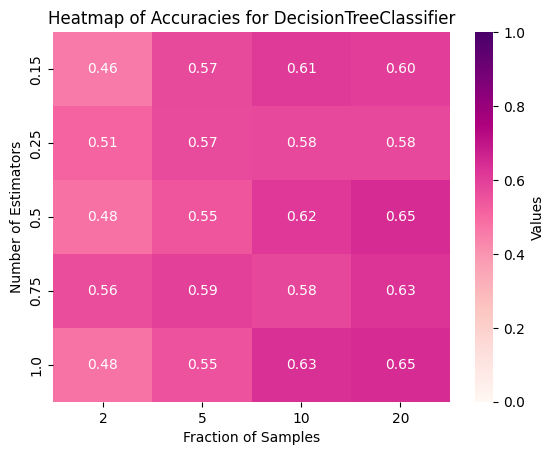

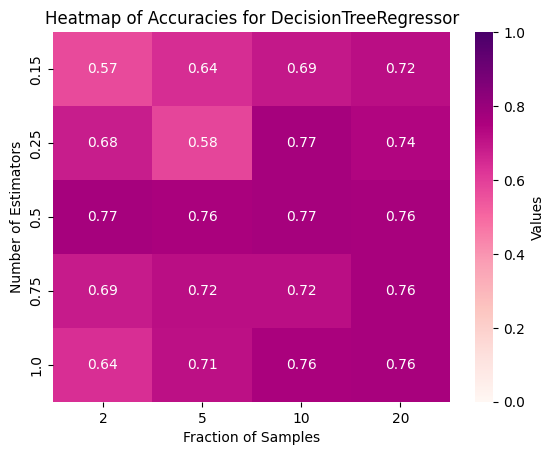

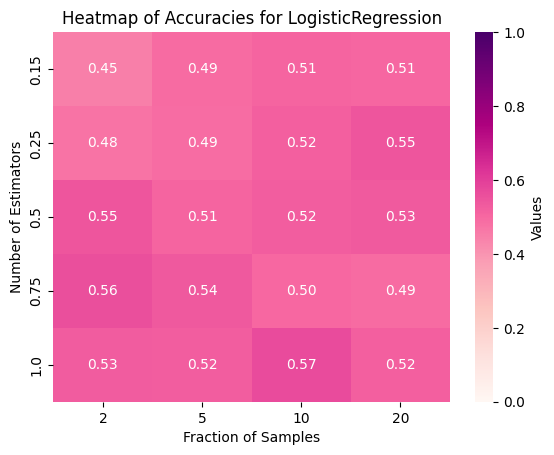

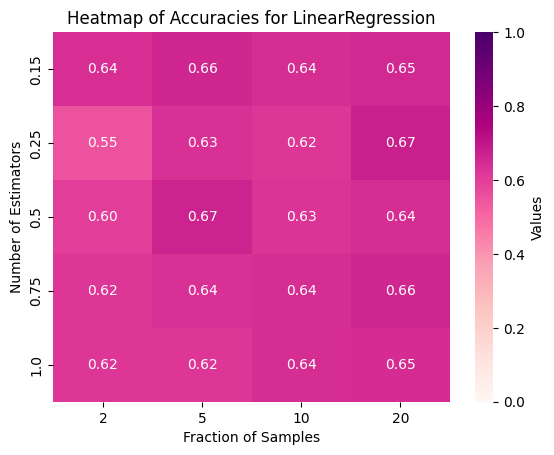

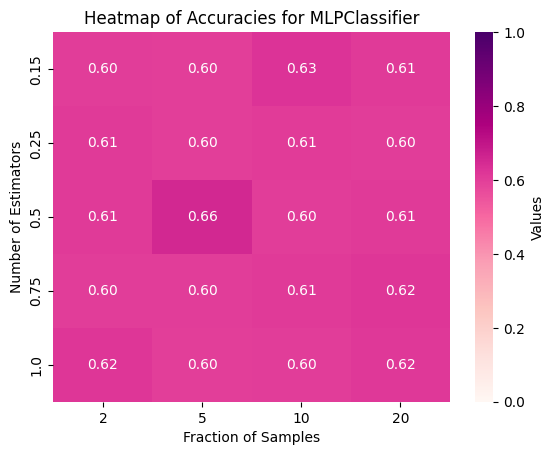

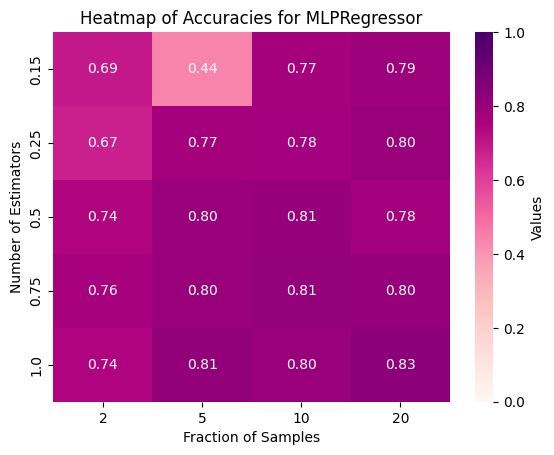

In [83]:
plotheatmap(accuracies_bagging_dt_classifier, 'DecisionTreeClassifier')
plotheatmap(accuracies_bagging_dt_regressor, 'DecisionTreeRegressor')
plotheatmap(accuracies_bagging_logreg, 'LogisticRegression')
plotheatmap(accuracies_bagging_linreg, 'LinearRegression')
plotheatmap(accuracies_bagging_mlp_classifier, 'MLPClassifier')
plotheatmap(accuracies_bagging_mlp_regressor, 'MLPRegressor')

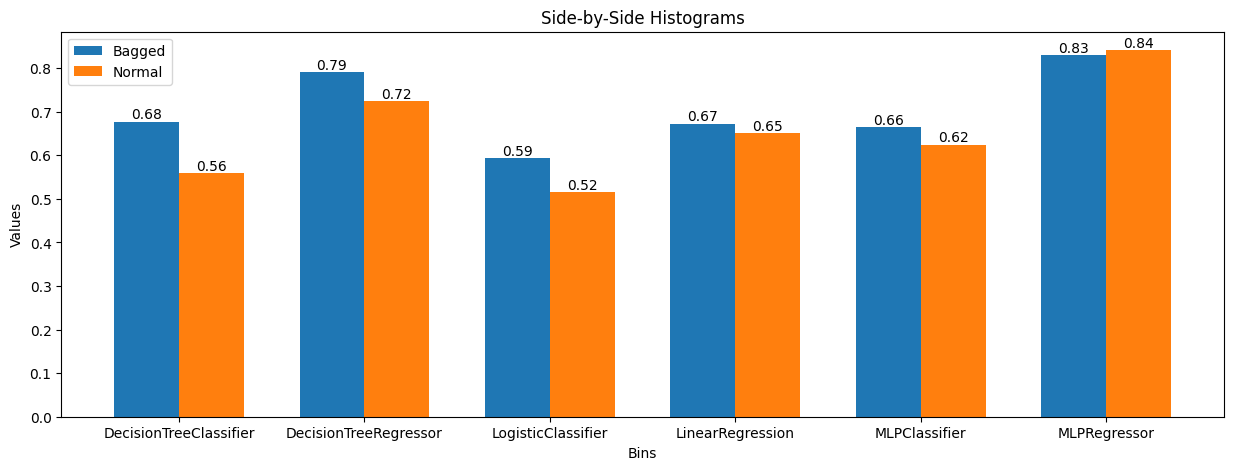

In [84]:
bins = ['DecisionTreeClassifier', 'DecisionTreeRegressor', 'LogisticClassifier', 'LinearRegression']
best_accuracies_bagged = [
    best_params_bagging_dt_classifier[-1],
    best_params_bagging_dt_regressor[-1],
    best_params_bagging_logreg[-1],
    best_params_bagging_linreg[-1]
]
best_accuracy_normal = [
    accuracy_score(wine_y_test, dt_classifier.predict(wine_X_test)),
    r2_score(housing_y_test, dt_regressor.predict(housing_X_test)),
    accuracy_score(wine_y_test, logreg.predict(wine_X_test)),
    r2_score(housing_y_test, linreg.predict(housing_X_test))
]

bins.extend(['MLPClassifier', 'MLPRegressor'])
best_accuracies_bagged.extend([
    best_params_bagging_mlp_classifier[-1],
    best_params_bagging_mlp_regressor[-1]
])
best_accuracy_normal.extend([
    mlp_classifier.evaluate(wine_X_test, wine_y_test),
    mlp_regressor.evaluate(housing_X_test, housing_y_test)[2]
])

# Using Chat-GPT
fig, ax = plt.subplots(figsize=(15, 5))
width = 0.35
ind = np.arange(len(bins))  # the x locations for the groups

rects1 = ax.bar(ind - width/2, best_accuracies_bagged, width, label='Bagged')
rects2 = ax.bar(ind + width/2, best_accuracy_normal, width, label='Normal')

for i, rect in enumerate(rects1):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2., height, '%.2f' % best_accuracies_bagged[i],
            ha='center', va='bottom')

for i, rect in enumerate(rects2):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2., height, '%.2f' % best_accuracy_normal[i],
            ha='center', va='bottom')

ax.set_xlabel('Bins')
ax.set_ylabel('Values')
ax.set_title('Side-by-Side Histograms')
ax.set_xticks(ind)
ax.set_xticklabels(bins)
ax.legend()

plt.show()

#### Stacking

In [85]:
# stacking_classifier = Stacking([dt_classifier, logreg], DecisionTreeClassifier, best_params_dt_classifier, method='stacking', n_fold=3, classification=True)
# stacking_classifier.fit(wine_X_train, wine_y_train)
# stacking_classifier.evaluate(wine_X_test, wine_y_test)

In [86]:
models_classifier = [dt_classifier, logreg, mlp_classifier]
models_regressor = [dt_regressor, linreg, mlp_regressor]

best_hyperparameter_classifier = {
    'method': None,
    'n_fold': None,
    'level1_model': None,
    'level1_params': None,
    'accuracy': -np.inf
}
best_hyperparameter_regressor = {
    'method': None,
    'n_fold': None,
    'level1_model': None,
    'level1_params': None,
    'accuracy': -np.inf
}

In [87]:
if mlp:
    with tqdm(total=6) as pbar:
        for method in ['stacking', 'blending']:
            for n_fold in [3,5,7]:
                stacking_classifier = Stacking(models_classifier, DecisionTreeClassifier, best_params_dt_classifier, method=method, n_fold=n_fold, classification=True)
                stacking_classifier.fit(wine_X_train, wine_y_train)
                accuracy = stacking_classifier.evaluate(wine_X_test, wine_y_test)

                if accuracy > best_hyperparameter_classifier['accuracy']:
                    best_hyperparameter_classifier = {
                        'method': method,
                        'n_fold': n_fold,
                        'level1_model': 'DecisionTreeClassifier',
                        'level1_params': best_params_dt_classifier,
                        'accuracy': accuracy
                    }
                
                stacking_classifier = Stacking(models_classifier, Logistic_Regression, best_params_logistic, method=method, n_fold=n_fold, classification=True)
                stacking_classifier.fit(wine_X_train, wine_y_train)
                accuracy = stacking_classifier.evaluate(wine_X_test, wine_y_test)

                if accuracy > best_hyperparameter_classifier['accuracy']:
                    best_hyperparameter_classifier = {
                        'method': method,
                        'n_fold': n_fold,
                        'level1_model': 'LogisticRegression',
                        'level1_params': best_params_logistic,
                        'accuracy': accuracy
                    }
                
                stacking_regressor = Stacking(models_regressor, DecisionTreeRegressor, best_params_dt_regressor, method=method, n_fold=n_fold, classification=False)
                stacking_regressor.fit(housing_X_train, housing_y_train)
                accuracy = stacking_regressor.evaluate(housing_X_test, housing_y_test)

                if accuracy > best_hyperparameter_regressor['accuracy']:
                    best_hyperparameter_regressor = {
                        'method': method,
                        'n_fold': n_fold,
                        'level1_model': 'DecisionTreeRegressor',
                        'level1_params': best_params_dt_regressor,
                        'accuracy': accuracy
                    }
                
                stacking_regressor = Stacking(models_regressor, Linear_Regression, best_params_linreg, method=method, n_fold=n_fold, classification=False)
                stacking_regressor.fit(housing_X_train, housing_y_train)
                accuracy = stacking_regressor.evaluate(housing_X_test, housing_y_test)

                if accuracy > best_hyperparameter_regressor['accuracy']:
                    best_hyperparameter_regressor = {
                        'method': method,
                        'n_fold': n_fold,
                        'level1_model': 'LinearRegression',
                        'level1_params': best_params_linreg,
                        'accuracy': accuracy
                    }
                pbar.update(1)
else:
    best_hyperparameter_classifier={'method': 'stacking', 'n_fold': 5, 'level1_model': 'DecisionTreeClassifier', 'level1_params': {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'random'}, 'accuracy': 0.5982532751091703}
    best_hyperparameter_regressor={'method': 'stacking', 'n_fold': 3, 'level1_model': 'DecisionTreeRegressor', 'level1_params': {'criterion': 'absolute_error', 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'splitter': 'best'}, 'accuracy': 0.7808412507378455}

In [88]:
print(f"Best hyperparameter for stacking classifier: {best_hyperparameter_classifier}")
print(f"Best hyperparameter for stacking regressor: {best_hyperparameter_regressor}")

Best hyperparameter for stacking classifier: {'method': 'stacking', 'n_fold': 5, 'level1_model': 'DecisionTreeClassifier', 'level1_params': {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'random'}, 'accuracy': 0.5982532751091703}
Best hyperparameter for stacking regressor: {'method': 'stacking', 'n_fold': 3, 'level1_model': 'DecisionTreeRegressor', 'level1_params': {'criterion': 'absolute_error', 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'splitter': 'best'}, 'accuracy': 0.7808412507378455}


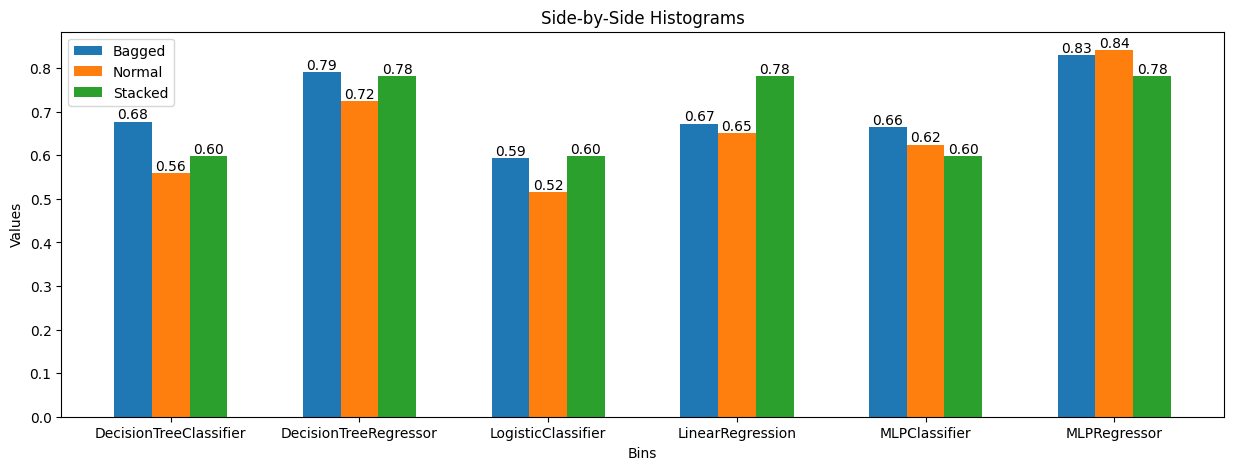

In [89]:
bins = ['DecisionTreeClassifier', 'DecisionTreeRegressor', 'LogisticClassifier', 'LinearRegression']
best_accuracies_bagged = [
    best_params_bagging_dt_classifier[-1],
    best_params_bagging_dt_regressor[-1],
    best_params_bagging_logreg[-1],
    best_params_bagging_linreg[-1]
]
best_accuracy_normal = [
    accuracy_score(wine_y_test, dt_classifier.predict(wine_X_test)),
    r2_score(housing_y_test, dt_regressor.predict(housing_X_test)),
    accuracy_score(wine_y_test, logreg.predict(wine_X_test)),
    r2_score(housing_y_test, linreg.predict(housing_X_test))
]
best_accuracies_stack = [
    best_hyperparameter_classifier['accuracy'],
    best_hyperparameter_regressor['accuracy'],
    best_hyperparameter_classifier['accuracy'],
    best_hyperparameter_regressor['accuracy']
]

bins.extend(['MLPClassifier', 'MLPRegressor'])
best_accuracies_bagged.extend([
    best_params_bagging_mlp_classifier[-1],
    best_params_bagging_mlp_regressor[-1]
])
best_accuracy_normal.extend([
    mlp_classifier.evaluate(wine_X_test, wine_y_test),
    mlp_regressor.evaluate(housing_X_test, housing_y_test)[2]
])
best_accuracies_stack.extend([
    best_hyperparameter_classifier['accuracy'],
    best_hyperparameter_regressor['accuracy']
])

# Using Chat-GPT
fig, ax = plt.subplots(figsize=(15, 5))
width = 0.2
ind = np.arange(len(bins))  # the x locations for the groups

rects1 = ax.bar(ind - width, best_accuracies_bagged, width, label='Bagged')
rects2 = ax.bar(ind, best_accuracy_normal, width, label='Normal')
rects3 = ax.bar(ind + width, best_accuracies_stack, width, label='Stacked')

for i, rect in enumerate(rects1):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2., height, '%.2f' % best_accuracies_bagged[i],
            ha='center', va='bottom')

for i, rect in enumerate(rects2):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2., height, '%.2f' % best_accuracy_normal[i],
            ha='center', va='bottom')

for i, rect in enumerate(rects3):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2., height, '%.2f' % best_accuracies_stack[i],
            ha='center', va='bottom')

ax.set_xlabel('Bins')
ax.set_ylabel('Values')
ax.set_title('Side-by-Side Histograms')
ax.set_xticks(ind)
ax.set_xticklabels(bins)
ax.legend()

plt.show()

#### Random Forest

In [90]:
best_params_rf_classifier = 0
best_accuracy_rf_classifier = -np.inf
best_params_rf_regressor = 0
best_accuracy_rf_regressor = -np.inf

In [91]:
for n_estimators in [2,5,10,20,30]:
    model = RandomForest(best_params_dt_classifier, n_estimators=n_estimators, classification=True)
    model.fit(wine_X_train, wine_y_train, wine_X_val, wine_y_val)
    accuracy = model.evaluate(wine_X_test, wine_y_test)

    if accuracy > best_accuracy_rf_classifier:
        best_accuracy_rf_classifier = accuracy
        best_params_rf_classifier = {'n_estimators': n_estimators, 'best_params': best_params_dt_classifier}
    
    model = RandomForest(best_params_dt_regressor, n_estimators=n_estimators, classification=False)
    model.fit(housing_X_train, housing_y_train, housing_X_val, housing_y_val)
    accuracy = model.evaluate(housing_X_test, housing_y_test)

    if accuracy > best_accuracy_rf_regressor:
        best_accuracy_rf_regressor = accuracy
        best_params_rf_regressor = {'n_estimators': n_estimators, 'best_params': best_params_dt_regressor}

print(f"Best n_estimators for RandomForestClassifier: {best_params_rf_classifier}")
print(f"Accuracy for RandomForestClassifier: {best_accuracy_rf_classifier}")
print(f"Best n_estimators for RandomForestRegressor: {best_params_rf_regressor}")  
print(f"Accuracy for RandomForestRegressor: {best_accuracy_rf_regressor}") 

Best n_estimators for RandomForestClassifier: {'n_estimators': 20, 'best_params': {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'random'}}
Accuracy for RandomForestClassifier: 0.62882096069869
Best n_estimators for RandomForestRegressor: {'n_estimators': 20, 'best_params': {'criterion': 'absolute_error', 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'splitter': 'best'}}
Accuracy for RandomForestRegressor: 0.7737389848111973


#### AdaBoost

In [92]:
wine_y_test1 = np.array([0 if y <= 5 else 1 for y in wine_y_test])
wine_y_train1 = np.array([0 if y <= 5 else 1 for y in wine_y_train])
wine_y_val1 = np.array([0 if y <= 5 else 1 for y in wine_y_val])

best_params_dt_classifier1 = best_params_dt_classifier.copy()
best_params_dt_classifier1['max_depth'] -= 1

In [93]:
no_estimators = [2,5,10,15,20,25,30]

In [94]:
accuracy_adaboost_classifier = []
time_adaboost_classifier = []
accuracy_adaboost_regressor = []
time_adaboost_regressor = []

for no_estimator in no_estimators:
    start_time = time.time()
    adaboost_classifier = AdaBoostClassifier(T=no_estimator, best_params=best_params_dt_classifier1)
    adaboost_classifier.fit(wine_X_train, wine_y_train1)
    accuracy = adaboost_classifier.evaluate(wine_X_test, wine_y_test1)
    end_time = time.time()

    accuracy_adaboost_classifier.append(accuracy)
    time_adaboost_classifier.append(end_time-start_time)

    start_time = time.time()
    adaboost_regressor = AdaBoostRegressor(T=no_estimator, best_params=best_params_dt_regressor)
    adaboost_regressor.fit(housing_X_train, housing_y_train)
    accuracy = adaboost_regressor.evaluate(housing_X_test, housing_y_test)
    end_time = time.time()

    accuracy_adaboost_regressor.append(accuracy)
    time_adaboost_regressor.append(end_time-start_time)

best_index = np.argmax(accuracy_adaboost_classifier)
best_accuracy_adaboost_classifier = accuracy_adaboost_classifier[best_index]
best_no_estimator_adaboost_classifier = no_estimators[best_index]

best_index = np.argmax(accuracy_adaboost_regressor)
best_accuracy_adaboost_regressor = accuracy_adaboost_regressor[best_index]
best_no_estimator_adaboost_regressor = no_estimators[best_index]

Best no. of estimators for AdaBoostClassifier: 20
Best accuracy for AdaBoostClassifier: 0.7467248908296943


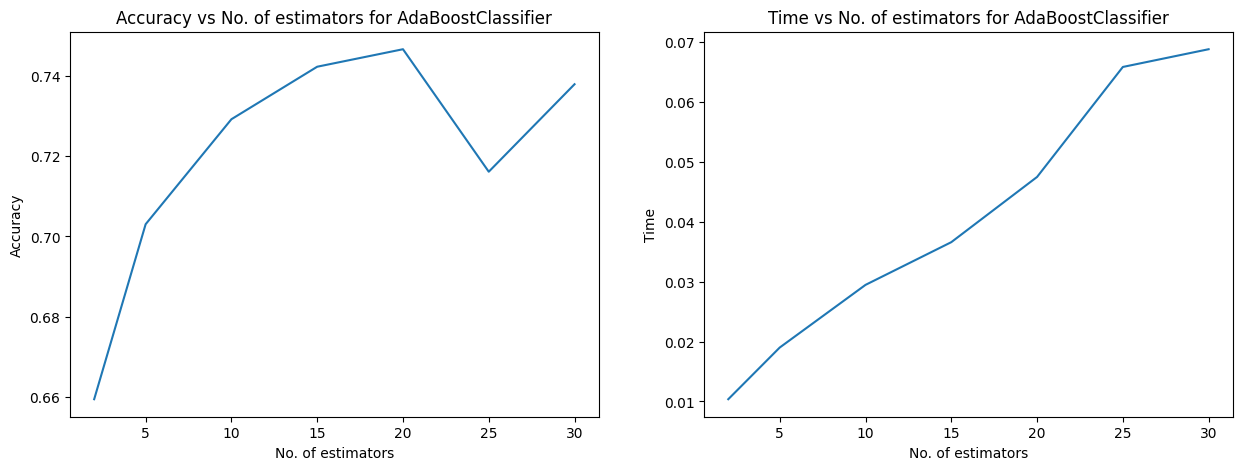

In [95]:
print(f"Best no. of estimators for AdaBoostClassifier: {best_no_estimator_adaboost_classifier}")
print(f"Best accuracy for AdaBoostClassifier: {best_accuracy_adaboost_classifier}")

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(no_estimators, accuracy_adaboost_classifier)
plt.xlabel('No. of estimators')
plt.ylabel('Accuracy')
plt.title('Accuracy vs No. of estimators for AdaBoostClassifier')

plt.subplot(1,2,2)
plt.plot(no_estimators, time_adaboost_classifier)
plt.xlabel('No. of estimators')
plt.ylabel('Time')
plt.title('Time vs No. of estimators for AdaBoostClassifier')
plt.show()

Best no. of estimators for AdaBoostRegressor: 30
Best score for AdaBoostRegressor: 0.8415938861023029


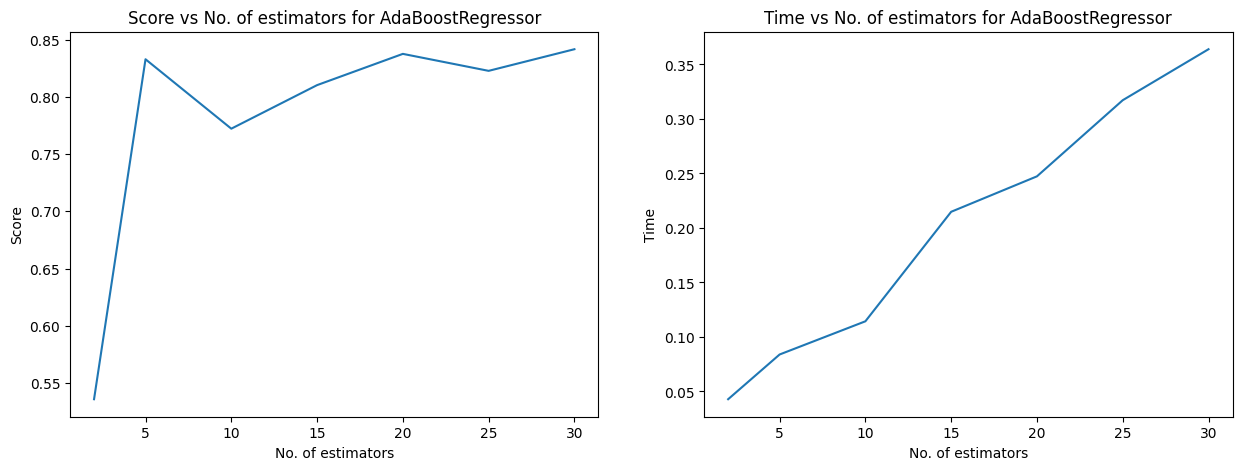

In [96]:
print(f"Best no. of estimators for AdaBoostRegressor: {best_no_estimator_adaboost_regressor}")
print(f"Best score for AdaBoostRegressor: {best_accuracy_adaboost_regressor}")

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(no_estimators, accuracy_adaboost_regressor)
plt.xlabel('No. of estimators')
plt.ylabel('Score')
plt.title('Score vs No. of estimators for AdaBoostRegressor')

plt.subplot(1,2,2)
plt.plot(no_estimators, time_adaboost_regressor)
plt.xlabel('No. of estimators')
plt.ylabel('Time')
plt.title('Time vs No. of estimators for AdaBoostRegressor')
plt.show()

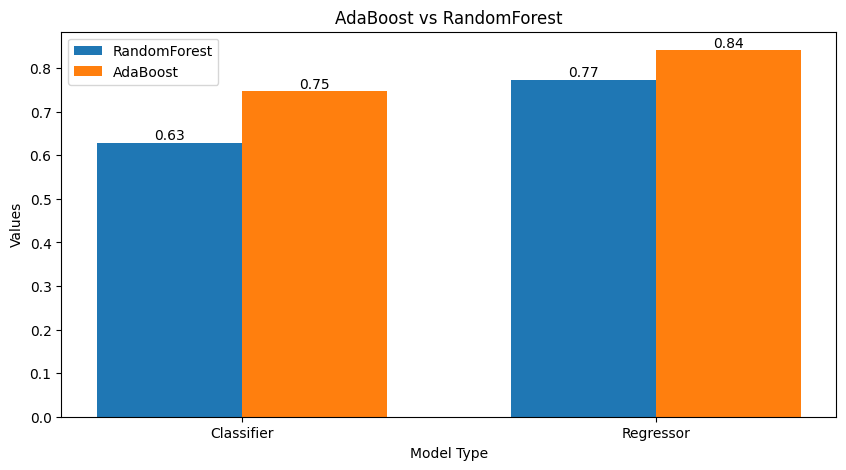

In [97]:
bins = ['Classifier', 'Regressor']
best_accuracies_rf = [
    best_accuracy_rf_classifier,
    best_accuracy_rf_regressor
]
best_accuracies_adaboost = [
    best_accuracy_adaboost_classifier,
    best_accuracy_adaboost_regressor
]

# Using Chat-GPT
fig, ax = plt.subplots(figsize=(10, 5))
width = 0.35
ind = np.arange(len(bins))  # the x locations for the groups

rects1 = ax.bar(ind - width/2, best_accuracies_rf, width, label='RandomForest')
rects2 = ax.bar(ind + width/2, best_accuracies_adaboost, width, label='AdaBoost')

for i, rect in enumerate(rects1):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2., height, '%.2f' % best_accuracies_rf[i],
            ha='center', va='bottom')

for i, rect in enumerate(rects2):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2., height, '%.2f' % best_accuracies_adaboost[i],
            ha='center', va='bottom')

ax.set_xlabel('Model Type')
ax.set_ylabel('Values')
ax.set_title('AdaBoost vs RandomForest')
ax.set_xticks(ind)
ax.set_xticklabels(bins)
ax.legend()

plt.show()

#### Gradient Boosting

In [98]:
# gradient_boosting_classifier = GradientBoostingClassifier(best_params=best_params_dt_regressor, n_trees=50, learning_rate=1.0, max_depth=1)
# gradient_boosting_classifier.fit(wine_X_train, wine_y_train1)
# gradient_boosting_classifier.evaluate(wine_X_test, wine_y_test1)

In [99]:
# gradient_boosting_regre = GradientBoostingRegressor(best_params=best_params_dt_regressor, n_trees=50, learning_rate=0.5)
# gradient_boosting_regre.fit(housing_X_train, housing_y_train)
# gradient_boosting_regre.evaluate(housing_X_test, housing_y_test)

In [100]:
no_trees = [10, 20, 50, 100]
learning_rates = [0.1, 0.5, 1.0]

In [101]:
accuracy_gb_classifier = []
time_gb_classifier = []
accuracy_gb_regressor = []
time_gb_regressor = []

with tqdm(total=len(no_trees)*len(learning_rates)) as pbar:
    for no_tree in no_trees:
        for learning_rate in learning_rates:
            start_time = time.time()
            gb_classifier = GradientBoostingClassifier(best_params=best_params_dt_regressor, n_trees=no_tree, learning_rate=learning_rate)
            gb_classifier.fit(wine_X_train, wine_y_train1)
            accuracy = gb_classifier.evaluate(wine_X_test, wine_y_test1)
            end_time = time.time()

            accuracy_gb_classifier.append([accuracy, no_tree, learning_rate])
            time_gb_classifier.append([end_time-start_time, no_tree, learning_rate])

            start_time = time.time()
            gb_regressor = GradientBoostingRegressor(best_params=best_params_dt_regressor, n_trees=no_tree, learning_rate=learning_rate)
            gb_regressor.fit(housing_X_train, housing_y_train)
            accuracy = gb_regressor.evaluate(housing_X_test, housing_y_test)
            end_time = time.time()

            accuracy_gb_regressor.append([accuracy, no_tree, learning_rate])
            time_gb_regressor.append([end_time-start_time, no_tree, learning_rate])

            pbar.update(1)

accuracy_gb_classifier = np.array(accuracy_gb_classifier)
time_gb_classifier = np.array(time_gb_classifier)
accuracy_gb_regressor = np.array(accuracy_gb_regressor)
time_gb_regressor = np.array(time_gb_regressor)

100%|██████████| 12/12 [00:13<00:00,  1.15s/it]


In [102]:
best_index = np.argmax(accuracy_gb_classifier, axis=0)[0]
best_accuracy_gb_classifier = accuracy_gb_classifier[best_index][0]
best_no_tree_gb_classifier = accuracy_gb_classifier[best_index][1]
best_learning_rate_gb_classifier = accuracy_gb_classifier[best_index][2]

best_index = np.argmax(accuracy_gb_regressor, axis=0)[0]
best_accuracy_gb_regressor = accuracy_gb_regressor[best_index][0]
best_no_tree_gb_regressor = accuracy_gb_regressor[best_index][1]
best_learning_rate_gb_regressor = accuracy_gb_regressor[best_index][2]

In [103]:
print(f"Best no. of estimators for GradientBoostingClassifier: {best_no_tree_gb_classifier}")
print(f"Best learning rate for GradientBoostingClassifier: {best_learning_rate_gb_classifier}")
print(f"Best accuracy for GradientBoostingClassifier: {best_accuracy_gb_classifier}")

fig = go.Figure(data=[go.Surface(z=accuracy_gb_classifier[:,0].reshape(len(no_trees), len(learning_rates)), x=no_trees, y=learning_rates)])
fig.update_layout(
    title='Accuracy vs No. of estimators and Learning Rate for GBC',
    autosize=False,
    width=500,
    height=500,
    margin=dict(l=65, r=50, b=65, t=90),
    scene=dict(
        xaxis_title='No. of Estimators',
        yaxis_title='Learning Rate',
        zaxis_title='Accuracy',
    )
)
fig.show()

fig = go.Figure(data=[go.Surface(z=time_gb_classifier[:,0].reshape(len(no_trees), len(learning_rates)), x=no_trees, y=learning_rates)])
fig.update_layout(
    title='Time vs No. of estimators and Learning Rate for GBC',
    autosize=False,
    width=500,
    height=500,
    margin=dict(l=65, r=50, b=65, t=90),
    scene=dict(
        xaxis_title='No. of Estimators',
        yaxis_title='Learning Rate',
        zaxis_title='Time'
    )
)
fig.show()

Best no. of estimators for GradientBoostingClassifier: 10.0
Best learning rate for GradientBoostingClassifier: 1.0
Best accuracy for GradientBoostingClassifier: 0.7248908296943232


In [104]:
print(f"Best no. of estimators for GradientBoostingRegressor: {best_no_tree_gb_regressor}")
print(f"Best learning rate for GradientBoostingRegressor: {best_learning_rate_gb_regressor}")
print(f"Best score for GradientBoostingRegressor: {best_accuracy_gb_regressor}")

fig = go.Figure(data=[go.Surface(z=accuracy_gb_regressor[:,0].reshape(len(no_trees), len(learning_rates)), x=no_trees, y=learning_rates)])
fig.update_layout(
    title='Score vs No. of estimators and Learning Rate for GBR',
    autosize=False,
    width=500,
    height=500,
    margin=dict(l=65, r=50, b=65, t=90),
    scene=dict(
        xaxis_title='No. of Estimators',
        yaxis_title='Learning Rate',
        zaxis_title='Score'
    )
)
fig.show()

fig = go.Figure(data=[go.Surface(z=time_gb_regressor[:,0].reshape(len(no_trees), len(learning_rates)), x=no_trees, y=learning_rates)])
fig.update_layout(
    title='Time vs No. of estimators and Learning Rate for GBR',
    autosize=False,
    width=500,
    height=500,
    margin=dict(l=65, r=50, b=65, t=90),
    scene=dict(
        xaxis_title='No. of Estimators',
        yaxis_title='Learning Rate',
        zaxis_title='Time'
    )
)
fig.show()

Best no. of estimators for GradientBoostingRegressor: 100.0
Best learning rate for GradientBoostingRegressor: 0.1
Best score for GradientBoostingRegressor: 0.8238011804080733


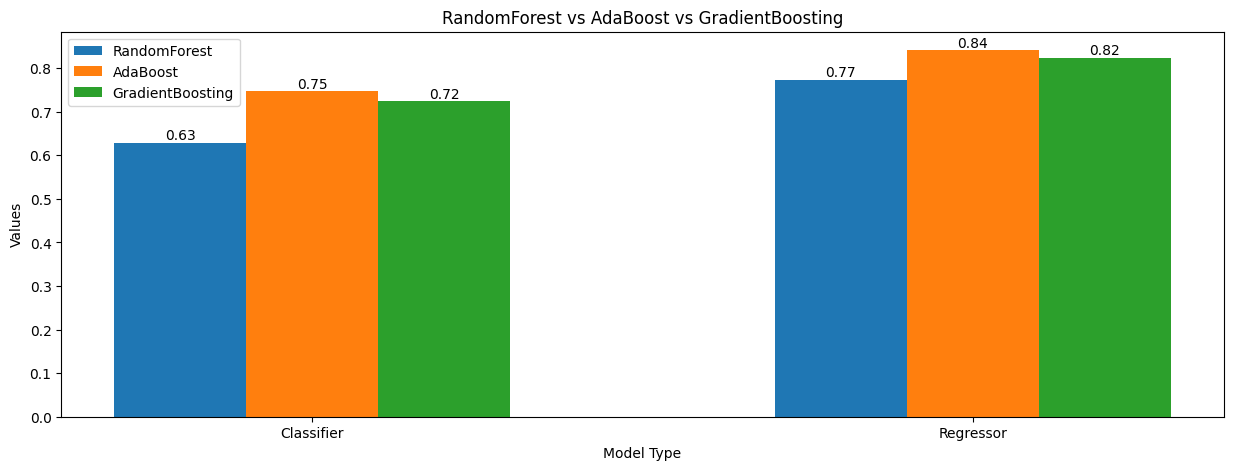

In [105]:
bins = ['Classifier', 'Regressor']
best_accuracies_rf = [
    best_accuracy_rf_classifier,
    best_accuracy_rf_regressor
]
best_accuracies_adaboost = [
    best_accuracy_adaboost_classifier,
    best_accuracy_adaboost_regressor
]
best_accuracies_gb = [
    best_accuracy_gb_classifier,
    best_accuracy_gb_regressor
]

# Using Chat-GPT
fig, ax = plt.subplots(figsize=(15, 5))
width = 0.2
ind = np.arange(len(bins))  # the x locations for the groups

rects1 = ax.bar(ind - width, best_accuracies_rf, width, label='RandomForest')
rects2 = ax.bar(ind, best_accuracies_adaboost, width, label='AdaBoost')
rects3 = ax.bar(ind + width, best_accuracies_gb, width, label='GradientBoosting')

for i, rect in enumerate(rects1):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2., height, '%.2f' % best_accuracies_rf[i],
            ha='center', va='bottom')

for i, rect in enumerate(rects2):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2., height, '%.2f' % best_accuracies_adaboost[i],
            ha='center', va='bottom')

for i, rect in enumerate(rects3):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2., height, '%.2f' % best_accuracies_gb[i],
            ha='center', va='bottom')

ax.set_xlabel('Model Type')
ax.set_ylabel('Values')
ax.set_title('RandomForest vs AdaBoost vs GradientBoosting')
ax.set_xticks(ind)
ax.set_xticklabels(bins)
ax.legend()

plt.show()

#### Analysis

In [106]:
y_gb_classifier = gb_classifier.predict(wine_X_test)
misclassified_indices = np.where(y_gb_classifier != wine_y_test1)[0]

misclassified_gb_samples = wine_X_test[misclassified_indices]
misclassified_gb_predictions = y_gb_classifier[misclassified_indices]
gb_true_labels = wine_y_test1[misclassified_indices]

y_adaboost_classifier = adaboost_classifier.predict(wine_X_test)
misclassified_ab_indices = np.where(y_adaboost_classifier != wine_y_test1)[0]

misclassified_ab_samples = wine_X_test[misclassified_ab_indices]
misclassified_ab_predictions = y_adaboost_classifier[misclassified_ab_indices]
ab_true_labels = wine_y_test1[misclassified_ab_indices]

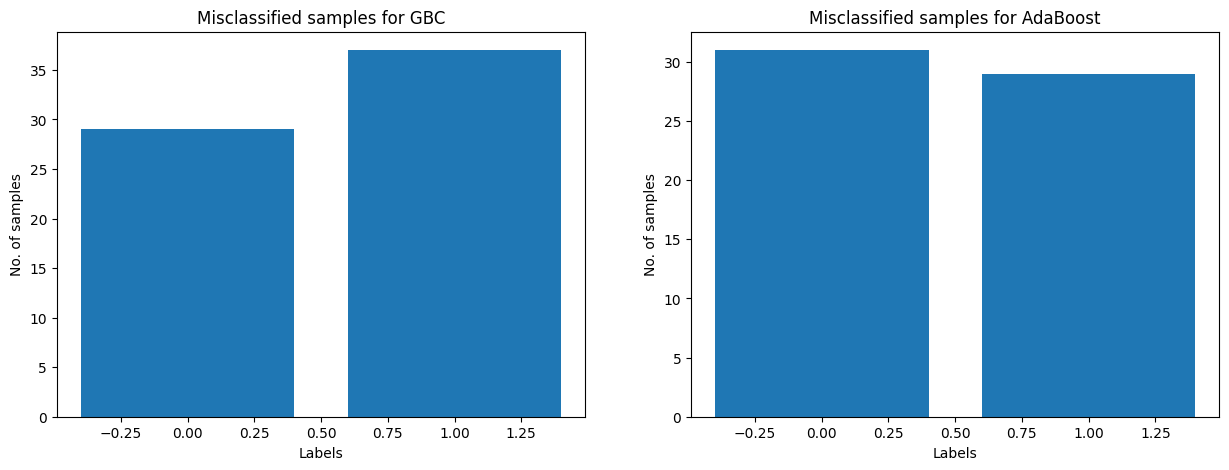

In [107]:
l_gb = []
l_ab = []
for i in [0,1]:
    indices = np.where(gb_true_labels == i)[0]
    l_gb.append([i, len(indices)])

    indices = np.where(ab_true_labels == i)[0]
    l_ab.append([i, len(indices)])

l = np.array(l_gb)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.bar(l[:,0], l[:,1])
plt.xlabel('Labels')
plt.ylabel('No. of samples')
plt.title('Misclassified samples for GBC')

l = np.array(l_ab)
plt.subplot(1,2,2)
plt.bar(l[:,0], l[:,1])
plt.xlabel('Labels')
plt.ylabel('No. of samples')
plt.title('Misclassified samples for AdaBoost')

plt.show()

We can see from the above graphs that Gradient Boost gives more missclassified samples for the class 1 than the class 0. Whereas adaboost gives almost equal number of missclassified samples for both the classes. 

In [108]:
misclassified_gb_samples.shape

(66, 12)

In [109]:
misclassified_gb_samples_df = pd.DataFrame(misclassified_gb_samples, columns=np.delete(np.array(wine_dataset.columns), -2))
misclassified_ab_samples_df = pd.DataFrame(misclassified_ab_samples, columns=np.delete(np.array(wine_dataset.columns), -2))

In [110]:
wine_X_test_df = pd.DataFrame(wine_X_test, columns=np.delete(np.array(wine_dataset.columns), -2))

wine_X_test_df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,Id
count,229.000000,229.000000,229.000000,229.000000,229.000000,229.000000,229.000000,229.000000,229.000000,229.000000,229.000000,229.000000
mean,0.121132,0.007137,0.052079,0.038461,0.038581,-0.035564,0.009266,0.098913,-0.082052,0.048326,0.010791,-0.091405
std,1.103820,1.015534,1.034898,1.137822,0.987244,1.006896,1.100433,1.018474,1.089614,1.095397,1.029509,0.989940
min,-1.895497,-1.956723,-1.365027,-0.982903,-1.120347,-1.231259,-1.187590,-3.061187,-2.880126,-1.278197,-1.887834,-1.729150
25%,-0.693319,-0.787162,-0.856379,-0.466421,-0.294891,-0.840863,-0.729823,-0.504313,-0.772786,-0.573658,-0.778491,-0.875322
50%,-0.120854,-0.007455,-0.042543,-0.245072,-0.104402,-0.255269,-0.333092,0.036165,-0.134198,-0.221388,-0.223820,-0.176737
75%,0.680598,0.605172,0.873023,0.050060,0.086088,0.525524,0.368817,0.732549,0.568248,0.424439,0.515741,0.739618
max,4.344377,4.448014,2.500695,9.494295,6.943716,5.112679,7.418423,3.616827,3.761188,7.587251,4.121103,1.692627


In [111]:
misclassified_gb_samples_df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,Id
count,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000
mean,-0.021106,0.099291,-0.041772,0.072419,0.169788,-0.110349,-0.195300,0.177977,0.094145,0.064163,-0.191138,-0.089413
std,1.088093,1.004758,1.071991,1.406380,1.319952,0.954468,0.751148,0.853307,1.183400,1.163063,0.877776,0.960066
min,-1.552017,-1.789643,-1.365027,-0.835337,-0.887526,-1.133660,-1.187590,-1.626843,-2.624691,-1.278197,-1.333163,-1.729150
25%,-0.807812,-0.606159,-1.072554,-0.466421,-0.289600,-0.816463,-0.722194,-0.262657,-0.820680,-0.558980,-0.755380,-0.748111
50%,-0.292593,0.048238,-0.144273,-0.318855,-0.104402,-0.499267,-0.409387,0.036165,0.217025,-0.280100,-0.362488,-0.142239
75%,0.537481,0.605172,0.707712,0.105397,0.144293,0.476724,0.170451,0.659792,0.887542,0.424439,0.145960,0.561738
max,4.344377,2.999987,2.093777,9.494295,6.943716,3.843891,2.474543,3.616827,2.611730,5.649769,4.121103,1.574040


In [112]:
misclassified_ab_samples_df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,Id
count,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000
mean,0.000318,0.091401,-0.064584,0.051290,0.229661,0.022888,-0.116416,0.178993,-0.050118,0.200356,-0.186329,0.171442
std,1.137830,0.912034,1.035850,1.423497,1.365475,1.136036,0.841499,0.886047,1.117722,1.254784,0.887811,0.978696
min,-1.552017,-1.789643,-1.365027,-0.761554,-0.718202,-1.231259,-1.187590,-1.626843,-2.880126,-1.278197,-1.887834,-1.709744
25%,-0.750566,-0.480849,-0.907244,-0.466421,-0.252560,-0.767664,-0.798488,-0.293838,-0.788751,-0.573658,-0.870937,-0.588018
50%,-0.292593,0.103932,-0.220570,-0.318855,-0.104402,-0.304068,-0.378869,0.036165,-0.006481,-0.192033,-0.177598,0.038876
75%,0.322807,0.605172,0.644131,0.050060,0.107253,0.647522,0.300152,0.672785,0.759825,0.571218,0.238406,1.063038
max,4.344377,2.721520,2.398965,9.494295,6.943716,3.843891,2.474543,3.616827,2.420153,5.649769,4.121103,1.666754


As we can see from the above data, and column `total sulfur dioxide` - the misclassified samples are for lower values of the column. This can be checked from the mean and max values for the column. \
Also, for the column `pH` - the misclassified samples come from higher value for the column. This can be checked from the mean for that column.

This is common between both the methods.
